In [3]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
from rpy2.robjects.packages import importr
from rpy2.robjects import globalenv
import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri

#rpy2.robjects.numpy2ri.activate()
#rpy2.robjects.pandas2ri.activate()

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
splatter = importr("splatter")
base = importr("base")
scuttle = importr("scuttle")
BiocSingular = importr("BiocSingular")
BiocGenerics = importr("BiocGenerics")
igraph = importr("igraph")
TSP = importr("TSP")
stats = importr("stats")
Revelio = importr("Revelio")

In [5]:
rpy2.robjects.numpy2ri.deactivate()
rpy2.robjects.pandas2ri.deactivate()
num_cells = 500
params_groups = splatter.newSplatParams(batchCells = num_cells, nGenes = 1000)
#print(type(base.c(0)))
args = (
    ("params", params_groups),
    ("de.prob", 1),
    ("de.facLoc", 5),
    ("path.from", base.c(0)),
    ("path.nSteps", num_cells),
    ("dropout.type", "none"),
    ("verbose", False)
)
sim1 = splatter.splatSimulatePaths.rcall(args, globalenv)
sim1 = scuttle.logNormCounts(sim1)
#sim1 = BiocSingular.runPCA(sim1, ntop=num_cells, ncomponents=num_cells/10)
#rpy2.robjects.numpy2ri.activate()
#rpy2.robjects.pandas2ri.activate()

<class 'rpy2.robjects.vectors.IntVector'>


In [55]:
list(sim1.slots)

NameError: name 'sim1' is not defined

In [7]:
class REXPR():
    def __init__(self, r_object):
        self.r_object = r_object
        
    def __getitem__(self, idxs: (tuple, str)):
        if isinstance(idxs, str):
            # If just passed a single index, don't
            # split it up in characters!
            return REXPR(self.r_object.slots[idxs])
        # Recursively iterate over every index
        temp = self.r_object
        for idx in idxs:
            temp = temp.slots[idx]
        return REXPR(temp)
    
    @property
    def slots(self):
        return list(self.r_object.slots)
    
    def __repr__(self):
        return f"[REXPR]: {repr(self.r_object)}"
    
    def __getattr__(self, attrname):
        return base.__dict__["$"](self.r_object, attrname)

In [353]:
sc_data = REXPR(sim1)
log_counts = np.array(sc_data['assays', 'data'].logcounts)
# Idx 0: Genes, Idx 1: Cells
print(log_counts.shape)

(1000, 500)


In [10]:
from sklearn.decomposition import PCA

In [536]:
pcad_vals = PCA(n_components=2).fit_transform(log_counts.T)
print(pcad_vals.shape)

(500, 2)


In [537]:
true_first_cell = np.array(sc_data['colData'].Step).argmin()
true_last_cell = np.array(sc_data['colData'].Step).argmax()
print(true_first_cell)
print(true_last_cell)

66
6


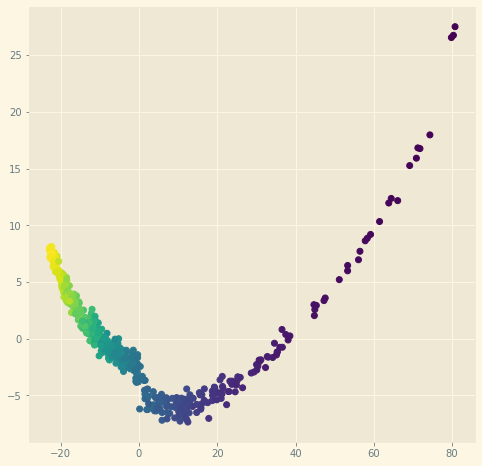

In [357]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*pcad_vals.T, c=np.array(sc_data['colData'].Step))

In [10]:
from Scripts.utilities import reconstruct_axes, binarize_matrix
from Scripts.antGLasso import antGLasso_heuristic, antGLasso
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic

# Naive Method

In [582]:
noise = np.random.random(log_counts.shape) / 1000
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic((log_counts+noise)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True,
    first_idx=true_first_cell
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering

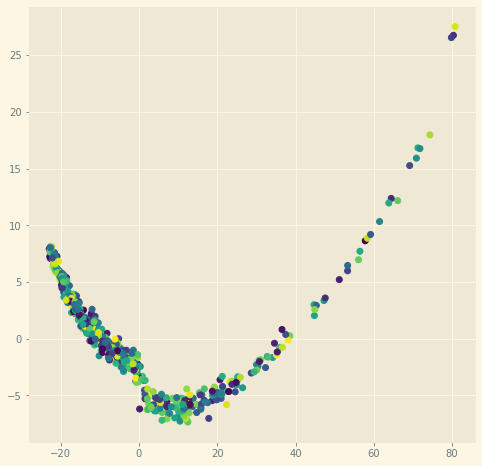

In [587]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    new_pca = PCA(n_components=2).fit_transform(unmixed.T).T
    ax.scatter(*new_pca, c=colors)

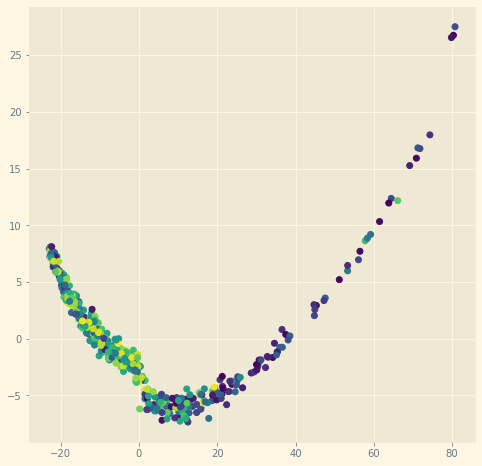

In [440]:
# This is just coloring them by the magnitude of the first
# gene in each cell!  Such a simple method
# is able to do much better than the sophisticated antGLasso.
unmixed_test = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [1],
    Psis=Psis
)[0]
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.argsort(np.argsort(unmixed_test[0]))
    ax.scatter(*pcad_vals.T, c=colors)

In [460]:
from scipy.sparse.csgraph import minimum_spanning_tree
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[1])).todense()).argmax(axis=1)

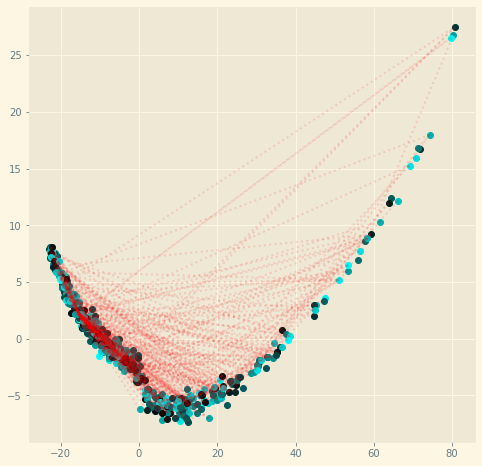

In [461]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

In [518]:
psi_as_graph = igraph.graph_from_adjacency_matrix(
    -np.abs(Psis[1]) + np.max(np.abs(Psis[1])),
    weighted=True,
    diag=False
)
# Add 1 b/c r starts from 1 not 0
TEST = igraph.graph_from_adjacency_matrix(
    (minimum_spanning_tree(-np.abs(Psis[1]) + np.max(np.abs(Psis[1]))).todense()),
    weighted=True,
    diag=False
)
print(TEST)
graph_ = REXPR(igraph.shortest_paths(
    igraph.as_undirected(TEST, mode="collapse"),
    true_first_cell + 1,
    true_last_cell + 1
)).vpath[0]
print(graph_)

IGRAPH 3965439 D-W- 500 499 -- 
+ attr: weight (e/n)
+ edges from 3965439:
 [1]  2->302  3->369  4->243  5->161  8->205  8->322  8->375  8->429 10->250
[10] 11->150 13->350 14->297 15->397 17-> 51 18->440 19->381 24-> 51 25-> 51
[19] 26->309 26->332 30-> 39 30->101 30->128 31->275 31->324 32->113 34-> 51
[28] 35->389 37->351 38->130 39->159 39->173 39->200 39->241 39->253 39->261
[37] 39->290 39->318 39->345 39->362 39->400 39->442 39->452 40->345 41-> 39
[46] 41->306 41->379 42-> 21 42->132 43-> 94 46->110 47-> 36 48->404 49->167
[55] 50->351 51->  1 51->  7 51->  9 51-> 16 51-> 54 51-> 77 51->124 51->151
[64] 51->184 51->199 51->217 51->218 51->254 51->297 51->302 51->305 51->324
+ ... omitted several edges

[ 67 132  51   7]


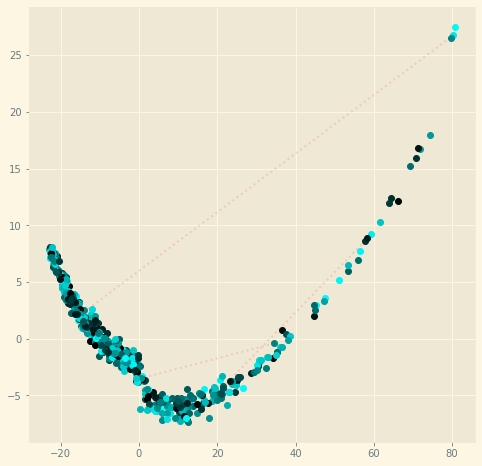

In [521]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        if idx >= len(graph_):
            break
        idx2 = graph_[idx]-1
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# Naive Method on PCA Values
Doesn't work - but that's fine b/c we don't really want to do this

In [538]:
noise = np.random.random(pcad_vals.shape) / 1000
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic((pcad_vals+noise)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [1],
    Psis=Psis,
    return_order=True
)
unmixed = unmixed.squeeze()
order = order[0]

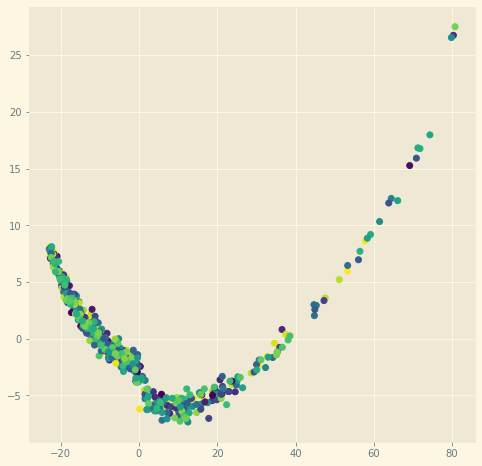

In [539]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    ax.scatter(*pcad_vals.T, c=colors)

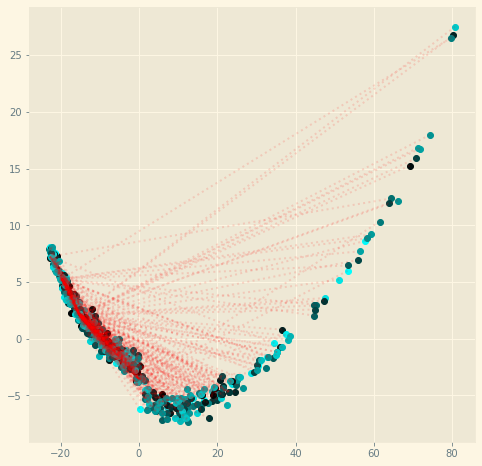

In [540]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[0])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# PCA the other way?

In [522]:
pcad_vals = PCA(n_components=2).fit_transform(log_counts)
print(pcad_vals.shape)

(1000, 2)


In [523]:
noise = np.random.random(log_counts.shape) / 1000
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic((log_counts+noise)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [1],
    Psis=Psis,
    return_order=True,
    first_idx=true_first_cell
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering

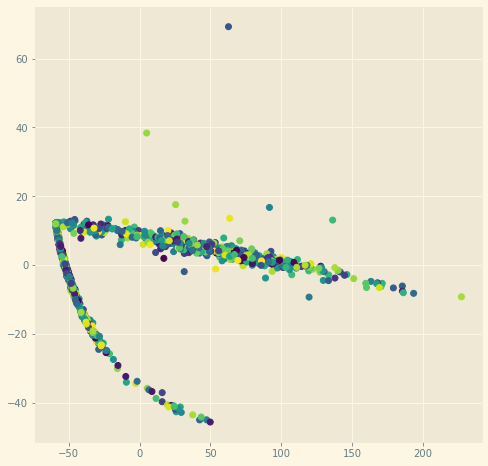

In [531]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    ax.scatter(*pcad_vals.T, c=colors)

In [534]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[0])).todense()).argmax(axis=1)

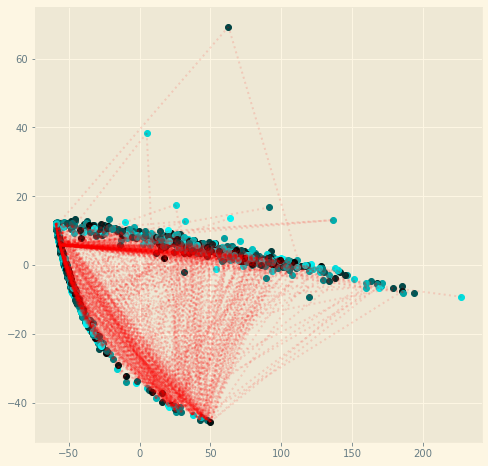

In [535]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# Fully synthetic data

In [1392]:
xs = np.linspace(0., 1., 100).reshape(-1, 1)
ys = xs**2
data = np.concatenate([xs, ys], axis=1)[np.newaxis, ...]
data = data + np.random.random((1000, 100, 2)) / 1000
print(data.shape)

(1000, 100, 2)


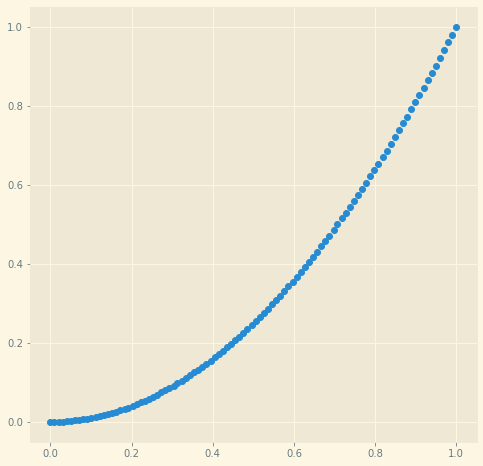

In [1393]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(data[0, :, 0], data[0, :, 1])

In [788]:
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic(data),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    data,
    [1],
    Psis=Psis,
    return_order=True,
    first_idx=0
)
order = order[0] # get ordering
print(unmixed[0, :10])

[[1.46444100e-04 4.89767137e-04]
 [1.00044091e+00 1.00070753e+00]
 [2.06919033e-02 1.12442743e-03]
 [5.15206770e-01 2.65894239e-01]
 [6.16983747e-01 3.80473690e-01]
 [3.34089122e-01 1.11990185e-01]
 [7.27487737e-01 5.29346412e-01]
 [6.26311469e-01 3.92266188e-01]
 [4.64656537e-01 2.16544021e-01]
 [6.56611022e-01 4.31805646e-01]]


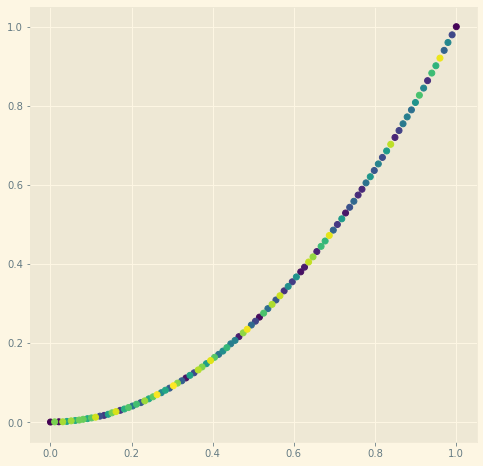

In [789]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*unmixed[0].T, c=range(0, unmixed.shape[1]))

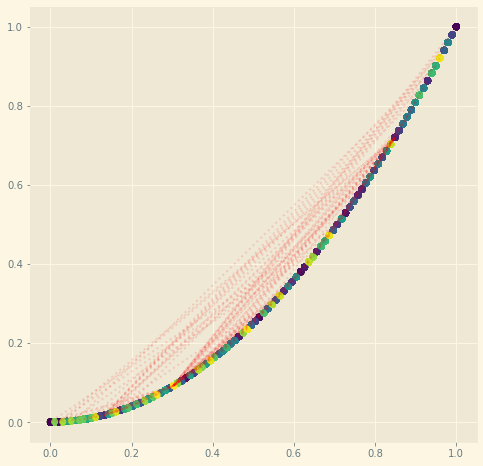

In [790]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[0])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(unmixed[0]):
        ax.scatter(*unmixed[0].T, c=range(0, unmixed.shape[1]))
    for idx, (x1, y1) in enumerate(unmixed[0]):
        idx2 = graph[idx]-1
        x2, y2 = unmixed[0, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

In [1395]:
Psis = antGLasso_heuristic(
    calculate_empirical_covariances(data),
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    data,
    [1],
    Psis=Psis,
    return_order=True,
    first_idx=0
)
order = order[0] # get ordering

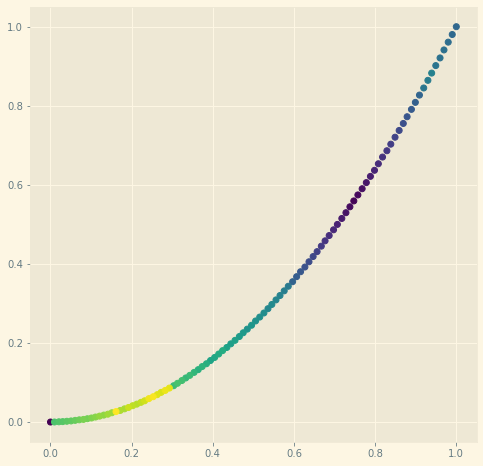

In [1397]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*unmixed[0].T, c=range(0, unmixed.shape[1]))
    fig.savefig("../../Plots/Fundamental Barriers/Simple temporal ordering")

# With more noise

In [759]:
samples = 10
noise1 = np.random.random((samples, 1, 500)) + 0.5
noise2 = np.random.random((samples, 1000, 1)) + 0.5
noise3 = np.random.random((samples, 1000, 500))
nonpara = nonparanormal_tensor_skeptic((log_counts*noise1*noise2+noise3/1000))

In [760]:
Psis = antGLasso_heuristic(
    nonpara,
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True,
    first_idx=true_first_cell
)
order = order[0]

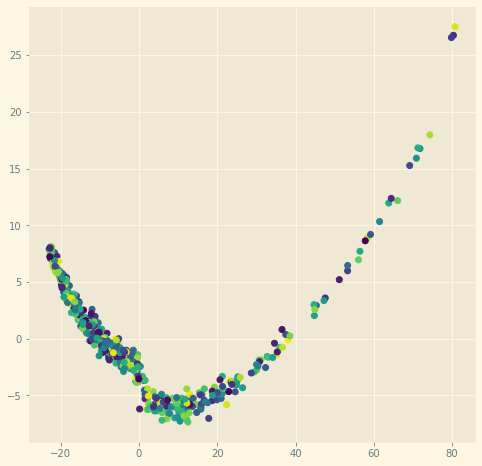

In [761]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)

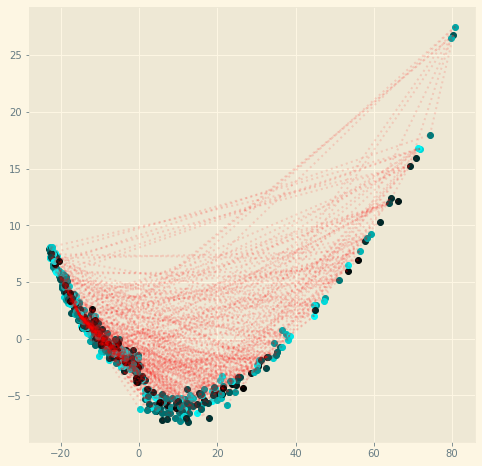

In [762]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(Psis[1])).todense()).argmax(axis=1)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        ax.scatter(x1, y1, color=(0, colors[idx], colors[idx]))
    for idx, (x1, y1) in enumerate(pcad_vals):
        idx2 = graph[idx]
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')

# As a clustering alg

In [11]:
rpy2.robjects.numpy2ri.deactivate()
num_cells = 200
params_groups = splatter.newSplatParams(batchCells = num_cells, nGenes = 10)
args = (
    ("params", params_groups),
    ("de.prob", 1),
    ("de.facLoc", 5),
    ("path.from", base.c(0)),
    ("path.nSteps", 2),
    ("dropout.type", "none"),
    ("verbose", False)
)
sim1 = splatter.splatSimulatePaths.rcall(args, globalenv)
sim1 = scuttle.logNormCounts(sim1)
sc_data = REXPR(sim1)
log_counts = np.array(sc_data['assays', 'data'].logcounts)
pcad_vals = PCA(n_components=2).fit_transform(log_counts.T)
#rpy2.robjects.numpy2ri.activate()

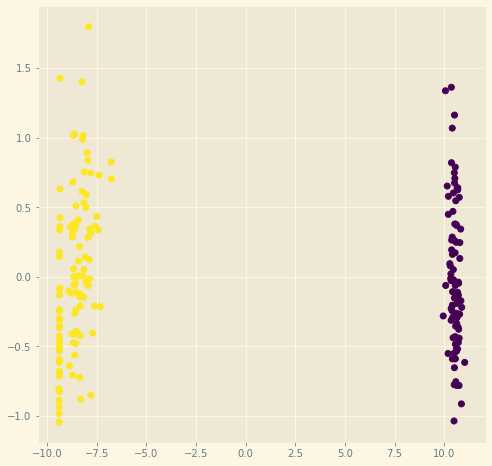

In [12]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*pcad_vals.T, c=np.array(sc_data['colData'].Step))

In [44]:
from Scripts.anBiGLasso import calculate_empirical_covariances
samples = 1
noise = np.random.random((samples, *log_counts.shape)) / 1000
#nonpara = nonparanormal_tensor_skeptic((log_counts+noise))
nonpara = calculate_empirical_covariances((log_counts + noise))

In [45]:
Psis = antGLasso_heuristic(
    nonpara,
    sparsities=[1, 1],
    B_approx_iters=5000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
order = order[0]

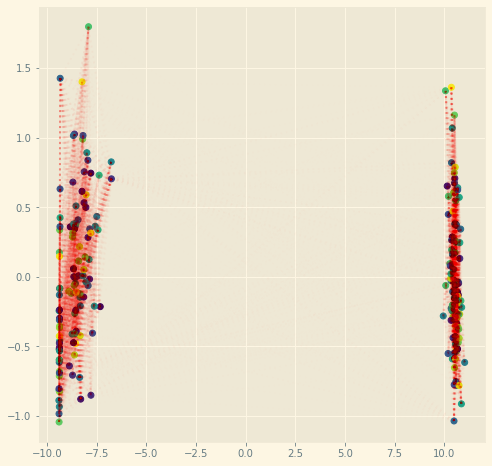

In [46]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(Psis[1][idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    #fig.savefig("../../Plots/Fundamental Barriers/EiGLasso Clustering")
    #fig.savefig("../../Plots/Fundamental Barriers/EiGLasso Clustering wo nonparanormal")
    #fig.savefig("../../Plots/Fundamental Barriers/antGLasso Clustering")
    fig.savefig("../../Plots/Fundamental Barriers/antGLasso Clustering wo nonparanormal")

In [47]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = -Psis[1][idx]#np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            if link < 0:
                # i.e. if it was a nonnegative value in original precision matrix
                continue
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    #fig.savefig("../../Plots/Fundamental Barriers/EiGLasso CovMat Clustering")
    #fig.savefig("../../Plots/Fundamental Barriers/antGLasso CovMat Clustering")
    #fig.savefig(
    #    "../../Plots/Fundamental Barriers/antGLasso CovMat Clustering without Nonparanormal"
    #)
    #fig.savefig(
    #    "../../Plots/Fundamental Barriers/"
    #    + "EigGLasso PrecMat Clustering with Nonparanormal with Negatives"
    #)
    fig.savefig(
        "../../Plots/Fundamental Barriers/"
        + "antGLasso PrecMat Clustering without Nonparanormal with Negatives"
    )

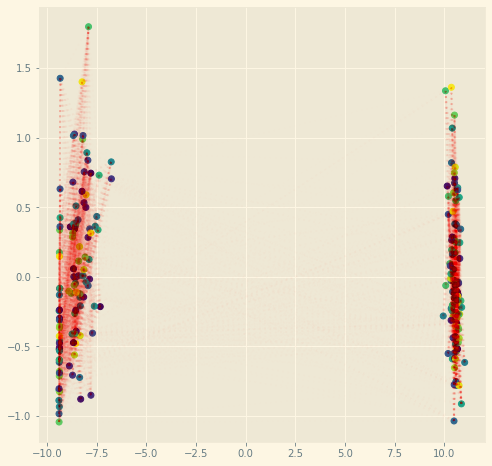

In [48]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/antGLasso CovMat Clustering without Nonparanormal"
    )

In [49]:
from Scripts.EiGLasso import EiGLasso_cov
Psis = EiGLasso_cov(
    T = nonpara[0],
    S = nonpara[1],
    beta_1=0,
    beta_2=0,
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
order = order[0]

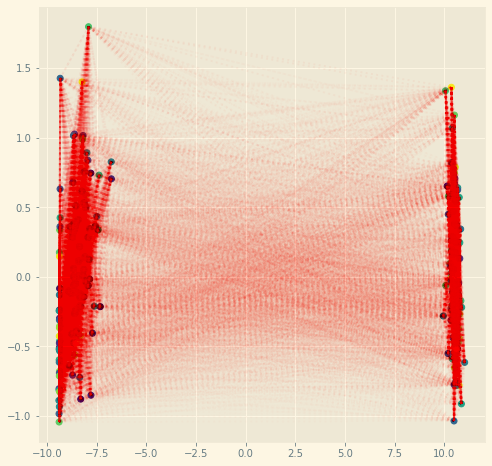

In [54]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(Psis[1][idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/EiGLasso Clustering wo nonparanormal")

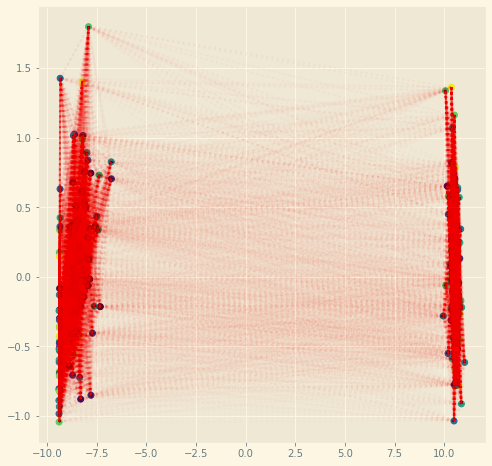

In [51]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = -Psis[1][idx]#np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            if link < 0:
                # i.e. if it was a nonnegative value in original precision matrix
                continue
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/"
        + "EiGLasso PrecMat Clustering without Nonparanormal with Negatives"
    )

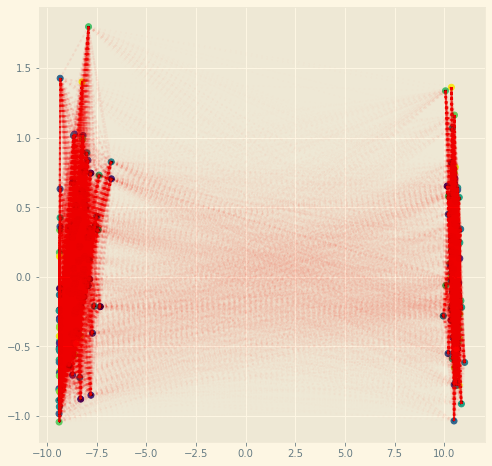

In [52]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/EiGLasso CovMat Clustering without Nonparanormal"
    )

In [55]:
nonpara = nonparanormal_tensor_skeptic((log_counts+noise))

In [67]:
Psis = antGLasso_heuristic(
    nonpara,
    sparsities=[1, 1],
    B_approx_iters=5000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
order = order[0]

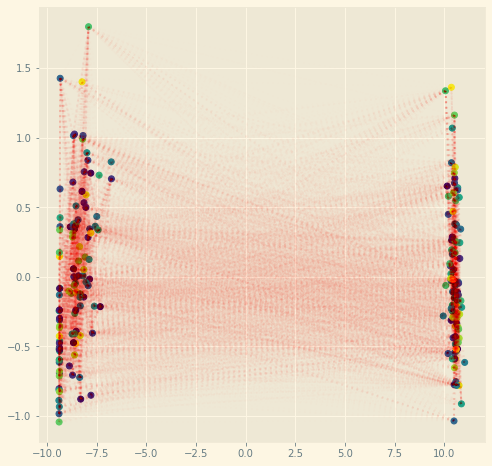

In [57]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(Psis[1][idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/antGLasso Clustering")

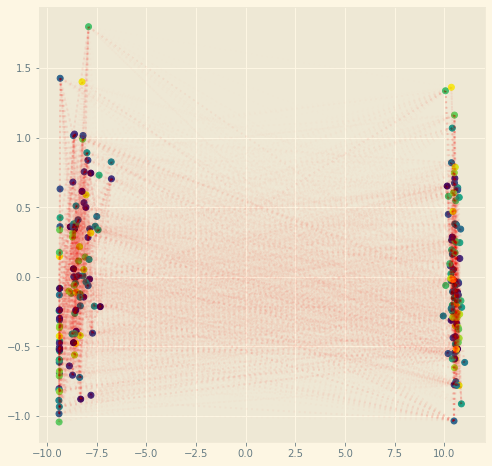

In [58]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = -Psis[1][idx]#np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            if link < 0:
                # i.e. if it was a nonnegative value in original precision matrix
                continue
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/"
        + "antGLasso PrecMat Clustering with Negatives"
    )

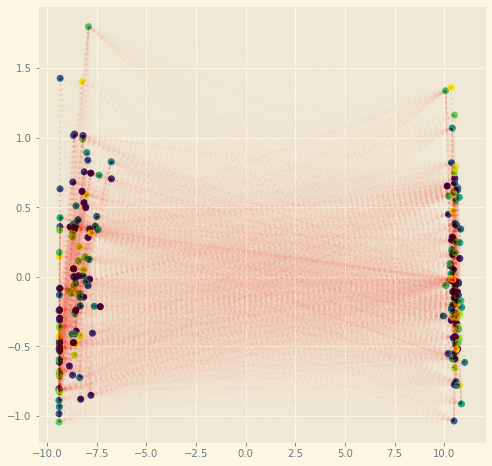

In [68]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.01*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/antGLasso CovMat Clustering"
    )

In [60]:
from Scripts.EiGLasso import EiGLasso_cov
Psis = EiGLasso_cov(
    T = nonpara[0],
    S = nonpara[1],
    beta_1=0,
    beta_2=0,
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
order = order[0]

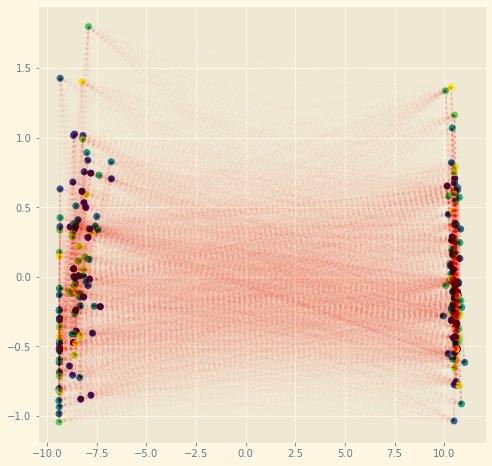

In [64]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(Psis[1][idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.01*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/EiGLasso Clustering")

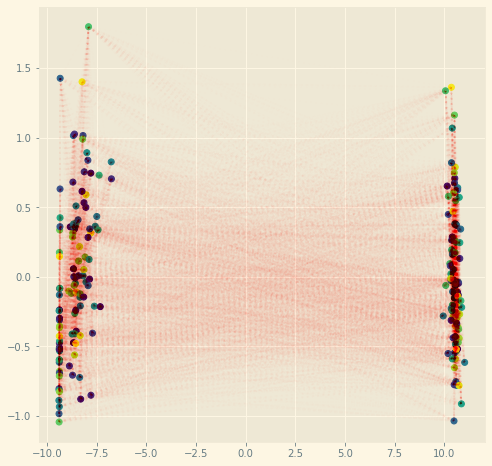

In [65]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = -Psis[1][idx]#np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            if link < 0:
                # i.e. if it was a nonnegative value in original precision matrix
                continue
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.01*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/"
        + "EiGLasso PrecMat Clustering with Negatives"
    )

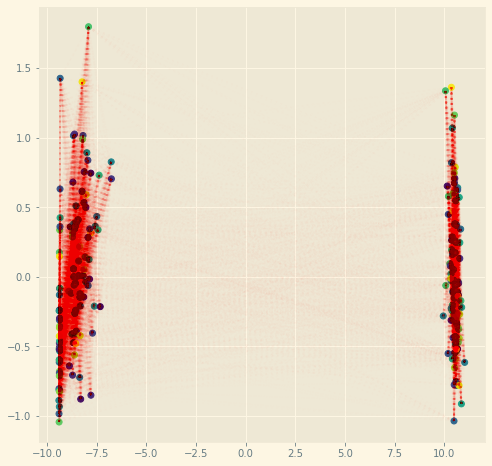

In [66]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.01*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/EiGLasso CovMat Clustering"
    )

In [69]:
Psis = antGLasso(
    log_counts+noise,
    sparsities=[1, 1],
    B_approx_iters=5000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
order = order[0]

In [73]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(Psis[1][idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/antGLasso Clustering no heuristic")

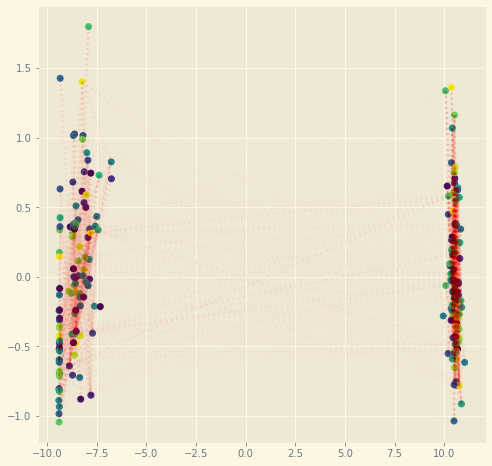

In [74]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = -Psis[1][idx]#np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            if link < 0:
                # i.e. if it was a nonnegative value in original precision matrix
                continue
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/"
        + "antGLasso PrecMat Clustering with Negatives no heuristic"
    )

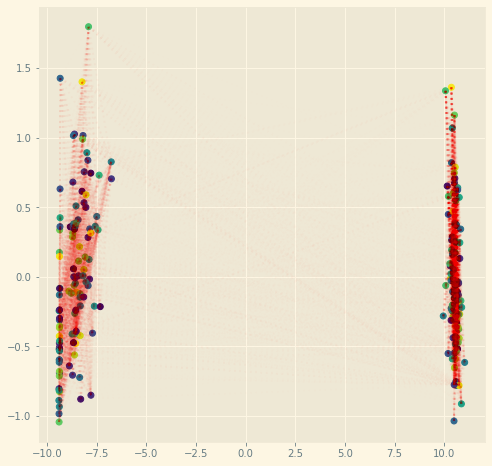

In [75]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = pcad_vals[idx2]
            # (do 0.01*link for EiGLasso to get better visual scaling,
            # 0.05 for antGLasso)
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    new_pca = PCA(n_components=2).fit_transform(unmixed[0].T).T
    ax.scatter(*new_pca, c=colors)
    fig.savefig(
        "../../Plots/Fundamental Barriers/antGLasso CovMat Clustering no heuristic"
    )

# What if we directly generate data from KS distribution?
To see if it even makes sense to do what we're trying to do!

In [1270]:
from Scripts.generate_data import fast_matrix_normal_ks, \
    generate_sparse_posdef_matrix, \
    fast_tensor_normal_ks

In [1405]:
dimensions = np.array([[1, 0.9], [0.9, 1]])
num_samples = 100
samples = generate_sparse_posdef_matrix(
    num_samples,
    num_samples**2 - num_samples
).squeeze()
print(dimensions.shape)
print(samples.shape)
datapoints = fast_tensor_normal_ks([dimensions, samples], 1).squeeze()
print(datapoints.shape)

(2, 2)
(100, 100)
(2, 100)


In [1406]:
graph = binarize_matrix(minimum_spanning_tree(-np.abs(samples)).todense()).argmax(axis=1)

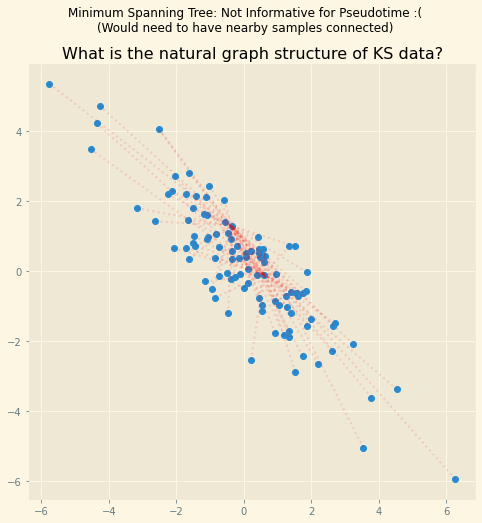

In [1407]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints)
    for idx, (x1, y1) in enumerate(datapoints.T):
        idx2 = graph[idx]
        x2, y2 = datapoints[:, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS MST.png")

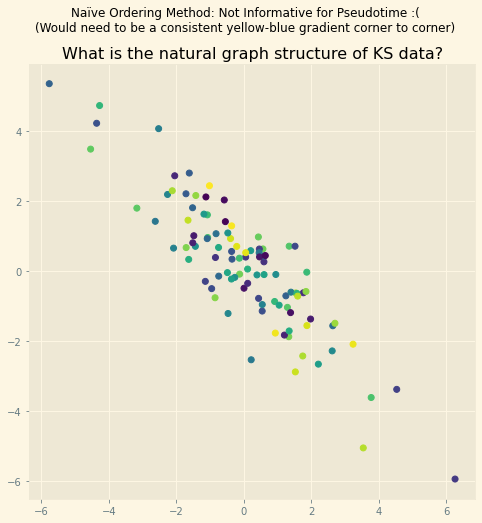

In [1408]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [2],
    Psis=[dimensions, samples],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Naive.png")

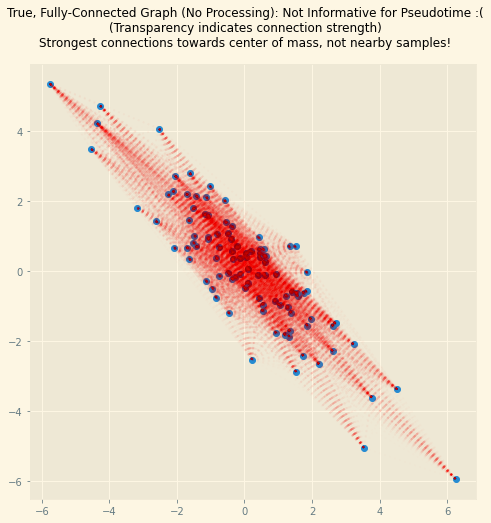

In [1409]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Full.png")

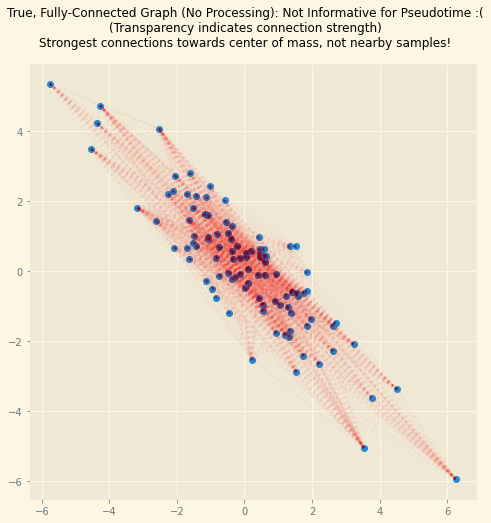

In [1410]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    cov_mat = np.linalg.inv(samples)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Full CovMat.png")

In [980]:
dimensions = np.array([[0.1, 0.9], [0.9, 1]])
num_samples = 100
samples = np.eye(num_samples)
rows, cols = np.indices((num_samples, num_samples))
samples[np.diag(rows, k=1), np.diag(cols, k=1)] = 0.01
samples[np.diag(rows, k=-1), np.diag(cols, k=-1)] = 0.01
datapoints = fast_tensor_normal_ks([dimensions, samples], 1).squeeze()

In [981]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints)
    for idx, (x1, y1) in enumerate(datapoints.T):
        idx2 = graph[idx]
        x2, y2 = datapoints[:, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS MST Tridiagonal.png")

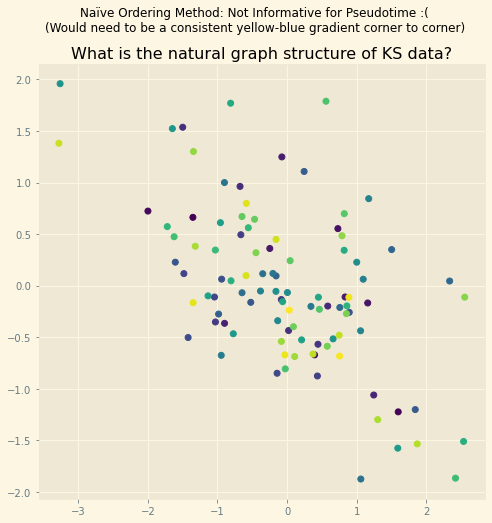

In [982]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [2],
    Psis=[dimensions, samples],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS Naive Tridiagonal.png")

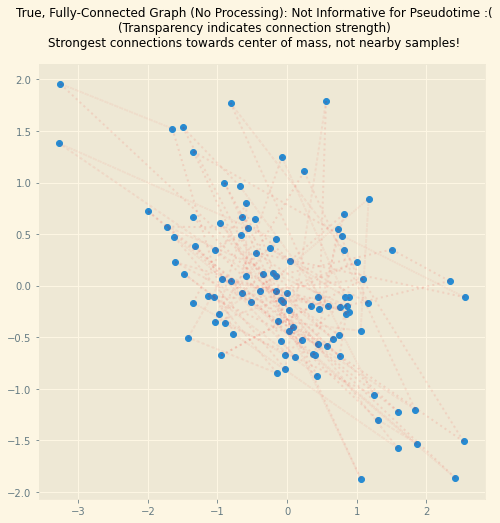

In [985]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS Full Tridiagonal.png")

# Other Graph Products

In [1252]:
dimensions = np.array([[0.01, 0.9], [0.9, 1]])
num_samples = 100
samples = generate_sparse_posdef_matrix(
    num_samples,
    num_samples**2 - num_samples,
).squeeze()

In [1253]:
def get_graph_product_for_precisions(Psi, Theta, graph_product: list):
    nss, \
    nse, \
    nst, \
    nes, \
    nee, \
    net, \
    nts, \
    nte, \
    ntt = graph_product
    I_psi = np.eye(Psi.shape[0])
    J_psi = np.ones(Psi.shape)
    I_theta = np.eye(Theta.shape[0])
    J_theta = np.ones(Theta.shape)
    A = nss * Theta + nse * I_theta + nst * J_theta
    B = nes * Theta + nee * I_theta + net * J_theta
    C = nts * Theta + nte * I_theta + ntt * J_theta
    return np.kron(Psi, A) + np.kron(I_psi, B) + np.kron(J_psi, C)
    
precisions = get_graph_product_for_precisions(
    samples,
    dimensions,
    [-1, -1, 1, -1, -1, 1, 1, 1, 0]
)

In [1254]:
from scipy.stats import multivariate_normal
datapoints = multivariate_normal.rvs(cov=np.linalg.inv(precisions))
datapoints = datapoints.reshape(100, 2)

/Users/baileyandrew/opt/anaconda3/envs/my_default_environment/lib/python3.9/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


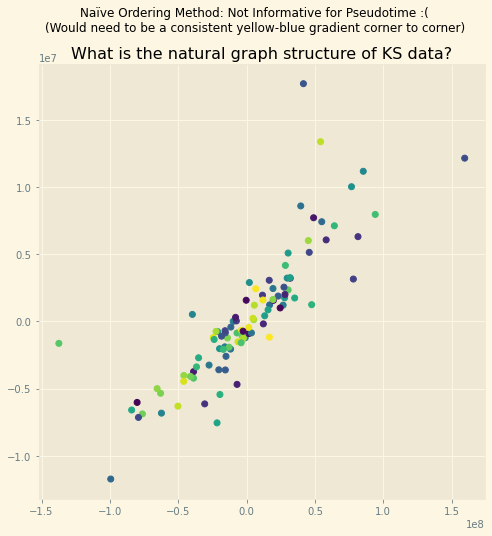

In [1255]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [1],
    Psis=[samples, dimensions],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints.T, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS Naive Tridiagonal.png")

In [1256]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints.T)
    for idx, (x1, y1) in enumerate(datapoints):
        idx2 = graph[idx]
        x2, y2 = datapoints[idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    #fig.savefig("../../Plots/Fundamental Barriers/KS MST Tridiagonal.png")

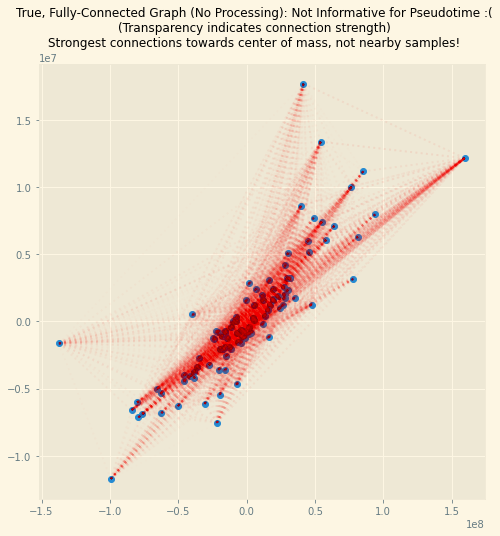

In [1257]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints.T)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )

# What if we had multiple samples?

In [1264]:
dimensions = np.array([[1, 0.9], [0.9, 1]])
num_samples = 100
samples = generate_sparse_posdef_matrix(
    num_samples,
    num_samples**2 - num_samples
).squeeze()
print(dimensions.shape)
print(samples.shape)
datapoints = fast_tensor_normal_ks([dimensions, samples], 1000)
print(datapoints.shape)
datapoints = datapoints.mean(axis=0)
datapoints.shape

(2, 2)
(100, 100)
(1000, 2, 100)


(2, 100)

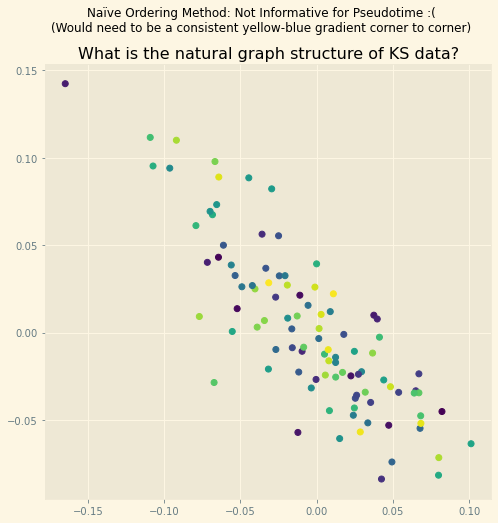

In [1267]:
unmixed, order = reconstruct_axes(
    datapoints[np.newaxis, ...],
    [2],
    Psis=[dimensions, samples],
    return_order=True
)
unmixed = unmixed.squeeze() # remove batch dim
order = order[0] # get ordering
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*datapoints, c=order)
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Naïve Ordering Method: Not Informative for Pseudotime :(\n"
        + "(Would need to be a consistent yellow-blue gradient corner to corner)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Naive.png")

In [1269]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    ax.scatter(*datapoints)
    for idx, (x1, y1) in enumerate(datapoints.T):
        idx2 = graph[idx]
        x2, y2 = datapoints[:, idx2]
        ax.plot([x1, x2], [y1, y2], c='#ff000022', linestyle=':')
    ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "Minimum Spanning Tree: Not Informative for Pseudotime :(\n"
        + "(Would need to have nearby samples connected)"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS MST.png")

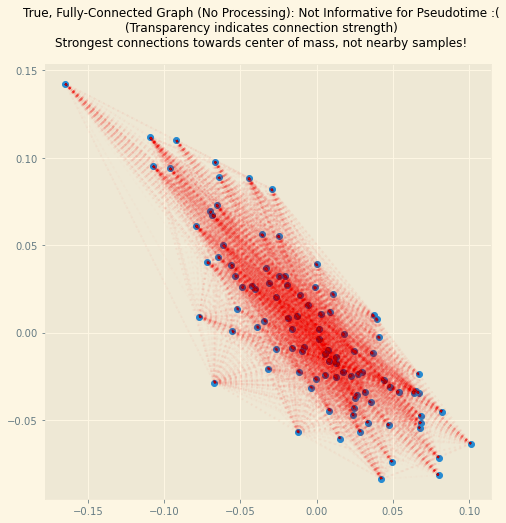

In [1268]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.array(order) / len(order)
    for idx, (x1, y1) in enumerate(datapoints.T):
        connections = np.abs(samples[idx])
        connections[idx] = 0 # set diagonal to zero
        max_connect = connections.max()
        for idx2, link in enumerate(connections):
            x2, y2 = datapoints[:, idx2]
            ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05*link / max_connect), linestyle=':')
    ax.scatter(*datapoints)
    #ax.set_title("What is the natural graph structure of KS data?")
    fig.suptitle(
        "True, Fully-Connected Graph (No Processing): Not Informative for Pseudotime :(\n"
        + "(Transparency indicates connection strength)\n"
        + "Strongest connections towards center of mass, not nearby samples!"
    )
    fig.savefig("../../Plots/Fundamental Barriers/KS Full.png")

# Without Heuristic

In [1398]:
rpy2.robjects.numpy2ri.deactivate()
num_cells = 500
params_groups = splatter.newSplatParams(batchCells = num_cells, nGenes = 1000)
args = (
    ("params", params_groups),
    ("de.prob", 1),
    ("de.facLoc", 5),
    ("path.from", base.c(0)),
    ("path.nSteps", num_cells),
    ("dropout.type", "none"),
    ("verbose", False)
)
sim1 = splatter.splatSimulatePaths.rcall(args, globalenv)
sim1 = scuttle.logNormCounts(sim1)
rpy2.robjects.numpy2ri.activate()

In [1399]:
sc_data = REXPR(sim1)
log_counts = np.array(sc_data['assays', 'data'].logcounts)
pcad_vals = PCA(n_components=2).fit_transform(log_counts.T)

In [1400]:
noise = np.random.random(log_counts.shape) / 1000
Psis = antGLasso(
    (log_counts+noise)[np.newaxis, ...],
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
unmixed = unmixed.squeeze()
order = order[0]

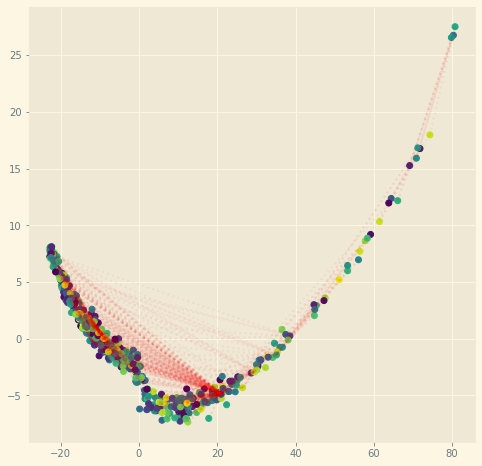

In [1401]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(Psis[1][idx])
        connections[idx] = 0 # set diagonal to zero
        idx2 = connections.argmax()
        connections[idx2] = 0 # set to zero to find second largest connection
        idx3 = connections.argmax()
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05), linestyle=':')
        x3, y3 = pcad_vals[idx3]
        ax.plot([x1, x3], [y1, y3], color=(1, 0, 0, 0.05), linestyle=':')
    ax.scatter(*pcad_vals.T, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/Single Cell Simulated Data")

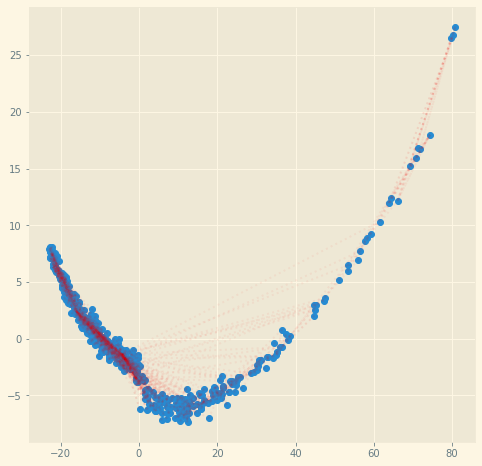

In [1404]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        idx2 = connections.argmax()
        connections[idx2] = 0 # set to zero to find second largest connection
        idx3 = connections.argmax()
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05), linestyle=':')
        x3, y3 = pcad_vals[idx3]
        ax.plot([x1, x3], [y1, y3], color=(1, 0, 0, 0.05), linestyle=':')
    ax.scatter(*pcad_vals.T)#, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/Single Cell Simulated Data CovMat")

In [1468]:
counts = sc_data['assays', 'data'].counts
noise = np.random.random(counts.shape) / 1000
Psis = antGLasso(
    (counts+noise)[np.newaxis, ...],
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
unmixed = unmixed.squeeze()
order = order[0]
pcad_vals = PCA(n_components=2).fit_transform(counts.T)

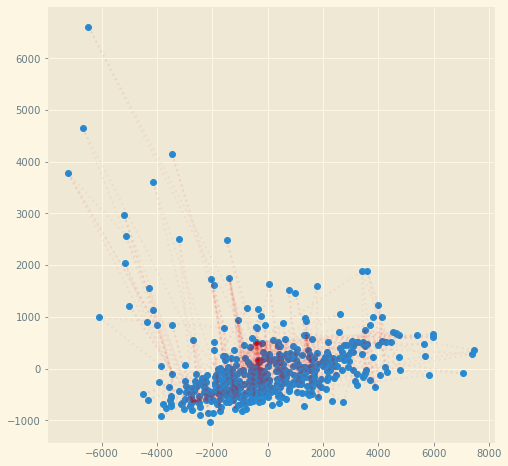

In [1469]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = order
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        idx2 = connections.argmax()
        connections[idx2] = 0 # set to zero to find second largest connection
        idx3 = connections.argmax()
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05), linestyle=':')
        x3, y3 = pcad_vals[idx3]
        ax.plot([x1, x3], [y1, y3], color=(1, 0, 0, 0.05), linestyle=':')
    ax.scatter(*pcad_vals.T)#, c=colors)
    fig.savefig("../../Plots/Fundamental Barriers/Single Cell Simulated Data CovMat NoLog")

# Real Data

In [1425]:
import os
csv1 = pd.read_csv(
    "../../../../../GSE142277_RAW 2.nosync/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt",
    sep='\t'
)
csv1

GENE  AACACGCAACTC  CTTGTAGCGTCT  CTACTATTCGCC  \
0                              A1BG             0             0             0   
1                               A2M             0             0             0   
2                           A2M-AS1             0             0             0   
3                             A2ML1             0             0             0   
4                             A2MP1             0             0             0   
...                             ...           ...           ...           ...   
25792  chr22-38_28785274-29006793.1             2             0             0   
25793                            pk            12             3             4   
25794                         snoR1             0             0             0   
25795                       snoZ196             0             1             0   
25796                    yR211F11.2             0             0             0   

       CACAGTCCGATN  AATTTAAACTTG  GACAACCTCATC  ACCATACACACG  TTTCAGGCAGAC  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
25792             1             0             0             0             0   
25793             3             0             3             4             3   
25794             0             0             0             0             0   
25795             0             0             0             0             0   
25796             0             0             0             0             0   

       TGTATCTTATAT  ...  CAATGAACAATC  TTACGGTAACTT  GAAAGGCTTGTC  \
0                 0  ...             0             0             0   
1                 0  ...             0             0             0   
2                 0  ...             0             0             0   
3                 0  ...             0             0             0   
4                 0  ...             0             0             0   
...             ...  ...           ...           ...           ...   
25792             0  ...             0             0             0   
25793             2  ...             0             0             0   
25794             0  ...             0             0             0   
25795             0  ...             0             0             0   
25796             0  ...             0             0             0   

       AACCCACTTAAT  TAACCCCTATAC  TCTCCTCTGTTT  AACGAATATTGG  GATACGTAGTAN  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
25792             0             0             0             0             0   
25793             0             0             0             0             0   
25794             0             0             0             0             0   
25795             0             0             0             0             0   
25796             0             0             0             0             0   

       CCCGTTCGGCTT  TAGTAACCTGCG  
0                 0             0  
1                 0             0  
2                 0             0  
3                 0             0  
4                 0             0  
...             ...           ...  
25792             0             0  
25793             0            

In [1426]:
csv2 = pd.read_csv(
    "../../../../../GSE142277_RAW 2.nosync/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt",
    sep='\t'
)
csv2

GENE  CGCTATGATTCA  GCGTGTGAGGAG  CCGATGTTTAGC  \
0                              A1BG             0             0             0   
1                          A1BG-AS1             0             0             0   
2                               A2M             0             3             0   
3                           A2M-AS1             1             1             0   
4                             A2MP1             0             0             0   
...                             ...           ...           ...           ...   
25399  chr22-38_28785274-29006793.1             0             0             0   
25400                            pk            12             6             8   
25401                         snoR1             0             0             0   
25402                       snoZ196             0             0             0   
25403                    yR211F11.2             0             0             0   

       TTCAAGCAGATC  GCAGTTGTTGCA  GCCCCGTAATGT  CAAAGCCCACTT  GTAATTCCTCGA  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             3             0   
3                 0             1             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
25399             1             0             0             0             0   
25400             4             0             2             2             1   
25401             1             0             0             0             0   
25402             0             0             0             0             0   
25403             0             0             0             0             0   

       AGCTTTGTGAGA  ...  GGTCCGGAGCAA  TCGCAACGACGG  ACCAATTGCATA  \
0                 0  ...             0             0             0   
1                 0  ...             0             0             0   
2                 0  ...             0             0             0   
3                 0  ...             0             0             0   
4                 0  ...             0             0             0   
...             ...  ...           ...           ...           ...   
25399             0  ...             0             0             0   
25400             1  ...             0             0             0   
25401             0  ...             0             0             0   
25402             0  ...             0             0             0   
25403             0  ...             0             0             0   

       TAGTTGGCAATT  GATCCTTTCTGA  TAACTCGCTGTA  GGTTCATAGGTT  CACAACATTCCT  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
25399             0             0             0             0             0   
25400             0             0             0             0             0   
25401             0             0             0             0             0   
25402             0             0             0             0             0   
25403             0             0             0             0             0   

       TAATACGTATCC  TTTCTTGTAACA  
0                 0             0  
1                 0             0  
2                 0             0  
3                 0             0  
4                 0             0  
...             ...           ...  
25399             0             0  
25400             0            

In [1439]:
csv3 = pd.read_csv(
    "../../../../../GSE142356_RAW.nosync/GSM4226257_out_gene_exon_tagged.dge_exonsds_046.txt",
    sep='\t'
)
csv3

GENE  CCACCTTTAAAA  CATAGTTCAATC  TCTCAACCTTGA  AGTCCTTATATT  \
0              A1BG             0             0             0             0   
1          A1BG-AS1             0             0             0             0   
2              A1CF             0             0             0             0   
3               A2M             0             0             0             0   
4           A2M-AS1             0             0             0             0   
...             ...           ...           ...           ...           ...   
26695  bP-21201H5.1             0             0             0             0   
26696  bP-21264C1.1             0             0             0             0   
26697  bP-21264C1.2             0             0             0             0   
26698   bP-2189O9.2             0             0             0             0   
26699         snoR1             0             0             0             0   

       CACGGTCAGTCT  CGATCATCTCAT  ACGTATCAAGCT  ATTATTTCATTA  CTACACTTAATT  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 1             0             0             0             0   
...             ...           ...           ...           ...           ...   
26695             0             0             0             0             0   
26696             0             0             0             0             0   
26697             0             0             0             0             0   
26698             0             0             0             0             0   
26699             0             0             0             0             0   

       ...  GTCCGCCTAACG  TTCGTCGTAAGA  AATATCCATGAA  ACGATTTACATT  \
0      ...             0             0             0             0   
1      ...             0             0             0             0   
2      ...             0             0             0             0   
3      ...             0             0             0             0   
4      ...             0             0             0             0   
...    ...           ...           ...           ...           ...   
26695  ...             0             0             0             0   
26696  ...             0             0             0             0   
26697  ...             0             0             0             0   
26698  ...             0             0             0             0   
26699  ...             0             0             0             0   

       GAACGTTATCGC  ACAACCTTATCA  CAGAGGGATAAC  CGCAATACTTTA  CCTATCCTACTT  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
26695             0             0             0             0             0   
26696             0             0             0             0             0   
26697             0             0             0             0             0   
26698             0             0             0             0             0   
26699             0             0             0             0             0   

       CACTGATCCCAT  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
26695             0  
26696             0  
26697             0  
26698             0  
26699             0  

[26700 rows x 3444 columns]

In [1443]:
csv3[csv3["GENE"].str[:3] == "CDK"]

GENE  CCACCTTTAAAA  CATAGTTCAATC  TCTCAACCTTGA  AGTCCTTATATT  \
3711        CDK1             1            27            20             8   
3712       CDK10             0             0             0             0   
3713      CDK11A             1             0             1             1   
3714      CDK11B             4             2             1             0   
3715       CDK12             5             2             1             1   
3716       CDK13             1             3             1             0   
3717       CDK14             0             0             0             2   
3718       CDK16             0             1             1             0   
3719       CDK17             1             0             3             1   
3720       CDK18             0             1             0             0   
3721       CDK19             0             1             0             1   
3722        CDK2             1             2             3             3   
3723       CDK20             0             0             0             0   
3724     CDK2AP1             0             0             0             0   
3725     CDK2AP2             2             3             4             3   
3726        CDK4             2             2             7             1   
3727        CDK5             1             0             1             2   
3728      CDK5R1             0             0             0             0   
3729      CDK5R2             0             0             0             0   
3730    CDK5RAP1             2             0             1             4   
3731    CDK5RAP2             1             3             3             1   
3732    CDK5RAP3             1             0             0             1   
3733        CDK6             0             1             1             4   
3734        CDK7             3             2             1             2   
3735        CDK8             0             0             1             0   
3736        CDK9             0             2             1             3   
3737      CDKAL1             2             0             0             2   
3738       CDKL1             0             0             0             0   
3739       CDKL2             0             0             0             0   
3740       CDKL3             0             0             0             0   
3741       CDKL4             0             0             0             0   
3742       CDKL5             0             0             0             0   
3743      CDKN1A             5             2             0             4   
3744      CDKN1B             4             1             2             4   
3745      CDKN1C             0             2             0             3   
3746      CDKN2A             3             4             9             9   
3747    CDKN2AIP             1             4             1             0   
3748  CDKN2AIPNL             0             3             1             1   
3749      CDKN2B             0             0             3             0   
3750   CDKN2B-AS             0             0             0             0   
3751  CDKN2B-AS1             0             0             0             0   
3752      CDKN2C             2             5             8             5   
3753      CDKN2D             1             0             0             1   
3754       CDKN3             2            11             9             8   

      CACGGTCAGTCT  CGATCATCTCAT  ACGTATCAAGCT  ATTATTTCATTA  CTACACTTAATT  \
3711            20            16            10            13             0   
3712             1             1             1             0             0   
3713             1             0             1             0             1   
3714             0             3             1             0             1   
3715             0             2             3             1             2   
3716             2             1             0             2             0   
3717             2             0             

In [1455]:
#csv3.drop("GENE", axis=1).loc[:, csv3.drop("GENE", axis=1).sum(axis=0) >= 500].shape
csv2.shape

(25404, 1194)

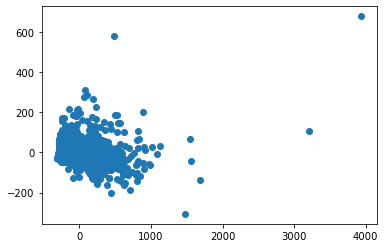

In [1461]:
plt.scatter(*PCA(n_components=2).fit_transform(csv2.drop("GENE", axis=1).T).T)

In [1473]:
# Dataset size is a bit too big, would take up a couple gigs of RAM
"""log_counts = np.log(csv2.drop("GENE", axis=1).to_numpy()+1)
noise = np.random.random(log_counts.shape) / 1000
Psis = antGLasso(
    (log_counts+noise)[np.newaxis, ...],
    sparsities=[1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    log_counts[np.newaxis, ...],
    [2],
    Psis=Psis,
    return_order=True
)
unmixed = unmixed.squeeze()
order = order[0]
pcad_vals = PCA(n_components=2).fit_transform(counts.T)"""

'log_counts = np.log(csv2.drop("GENE", axis=1).to_numpy()+1)\nnoise = np.random.random(log_counts.shape) / 1000\nPsis = antGLasso(\n    (log_counts+noise)[np.newaxis, ...],\n    sparsities=[1, 1],\n    B_approx_iters=1000\n)\nunmixed, order = reconstruct_axes(\n    log_counts[np.newaxis, ...],\n    [2],\n    Psis=Psis,\n    return_order=True\n)\nunmixed = unmixed.squeeze()\norder = order[0]\npcad_vals = PCA(n_components=2).fit_transform(counts.T)'

In [1479]:
cycle_genes = pd.read_csv("../../Data/revelioTestData_cyclicGenes.csv", index_col='Unnamed: 0')
cycle_genes

G1.S       S         G2     G2.M    M.G1
1      ABCA7   ABCC2     ALKBH1     ADH4   AFAP1
2        ACD   ABCC5       ANLN     AHI1   AGFG1
3      ACYP1  ABHD10      AP3D1  AKIRIN2  AGPAT3
4    ADAMTS1    ACPP  ARHGAP11B  ANKRD40  AKAP13
5      ADCK2  ADAM22   ARHGAP19     ANLN    AMD1
..       ...     ...        ...      ...     ...
212      NaN     NaN        NaN   ZC3HC1     NaN
213      NaN     NaN        NaN      ZFX     NaN
214      NaN     NaN        NaN    ZMYM1     NaN
215      NaN     NaN        NaN   ZNF207     NaN
216      NaN     NaN        NaN   ZNF521     NaN

[216 rows x 5 columns]

In [1497]:
csv2 = csv2.set_index("GENE")

In [1498]:
myData = Revelio.createRevelioObject(
    rawData = csv2,
    cyclicGenes = cycle_genes
)

2022-07-21 12:06:49: reading data: 18.78secs


In [1499]:
myData = Revelio.getPCAData(dataList = myData)

2022-07-21 12:07:27: calculating PCA: 

R[write to console]: Error in `[.data.frame`(dataList@cellInfo, , "ccPhase") : 
  undefined columns selected



RRuntimeError: Error in `[.data.frame`(dataList@cellInfo, , "ccPhase") : 
  undefined columns selected


In [ ]:
myData = ReveliogetOptimalRotation(dataList = myData, boolPlotResults = True)

In [ ]:
myData = getExtrapolatedStateInDCSpace(dataList = myData, boolPlotResults = True)

# Revelio

In [6]:
dcData = pd.read_csv(
    "../../Data/dcData.csv",
    sep=','
).set_index("Unnamed: 0")

In [7]:
dcData

WT_CTTGTAGCGTCT  WT_AATTTAAACTTG  WT_GACAACCTCATC  \
Unnamed: 0                                                      
DC1                1.984931         5.600212        -5.231942   
DC2                7.324441         7.644215         6.629951   
DC3                4.588305         1.703998         8.363564   
DC4               -2.429236         0.094475        -2.107420   
DC5               -1.763308        -2.394825        -3.715900   
...                     ...              ...              ...   
DC1027             0.067349         0.248655        -0.038381   
DC1028             0.253110         0.368665         0.124011   
DC1029             0.209869         0.119231         0.091847   
DC1030             0.033729        -0.214225         0.174388   
DC1031             0.299228         0.044785        -0.053000   

            WT_ACCATACACACG  WT_TTTCAGGCAGAC  WT_TGTATCTTATAT  \
Unnamed: 0                                                      
DC1               -1.682023        -4.824020         1.366247   
DC2                7.892230         4.133230        -2.709810   
DC3                5.966579         0.598196         3.926564   
DC4               -3.643042         0.635265        -3.904118   
DC5               -1.057436        -3.157206        -1.908449   
...                     ...              ...              ...   
DC1027             0.083241         0.184915        -0.013227   
DC1028            -0.017807         0.435540         0.004397   
DC1029            -0.036733        -0.124055         0.054119   
DC1030             0.007693        -0.193828        -0.051806   
DC1031             0.281340        -0.484164         0.116874   

            WT_AAATGTGTCTTC  WT_GTGTCAGGAGCA  WT_CCCGAAGTTATC  \
Unnamed: 0                                                      
DC1               -3.006857        -0.542578         7.674438   
DC2               -0.921289        -0.005799         4.834405   
DC3                2.834197         1.578387         5.397794   
DC4               -4.119977        -0.296326        -2.876769   
DC5               -3.011718        -4.239489        -2.863486   
...                     ...              ...              ...   
DC1027             0.271366        -0.049763        -0.082329   
DC1028             0.109324         0.048334         0.103786   
DC1029            -0.172657         0.172650         0.090151   
DC1030             0.470368        -0.153529         0.095080   
DC1031             0.106025         0.172076        -0.182837   

            WT_AACATTGGAACC  ...  Ago2KO_TTAAAGGGGGCT  Ago2KO_CATAACCTCGTT  \
Unnamed: 0                   ...                                             
DC1                6.681426  ...            -5.294246             3.024843   
DC2                7.101090  ...            -4.304406            -5.111268   
DC3                4.241652  ...            -9.339799           -15.349724   
DC4               -3.330401  ...             3.257449            -2.065597   
DC5               -2.994747  ...             0.550956             1.789667   
...                     ...  ...                  ...                  ...   
DC1027             0.264417  ...            -0.070168             0.098343   
DC1028             0.166766  ...             0.000281             0.159808   
DC1029            -0.023106  ...             0.178053            -0.231816   
DC1030            -0.059424  ...             0.040701            -0.019291   
DC1031            -0.234805  ...             0.036846             0.095212   

            Ago2KO_ACGAGACTCTGC  Ago2KO_ATCTTATTTGGC  Ago2KO_AACTGTCGCCAC  \
Unnamed: 0                                                                  
DC1                   -4.168029             1.747815             9.420871   
DC2                   -3.553858            -4.015490            -8.780352   
DC3                  -11.127164           -15.032750            -3.077086   
DC4                    2.305605            -4.236795             3.409714 

<AxesSubplot:xlabel='DC1', ylabel='DC2'>

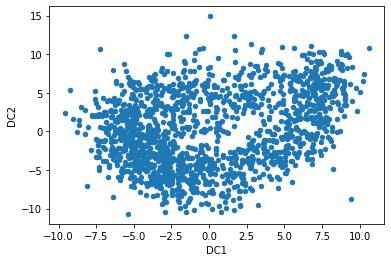

In [8]:
dcData.T.plot.scatter(x="DC1", y="DC2")

In [12]:
from Scripts.anBiGLasso import calculate_empirical_covariances
Psis = antGLasso_heuristic(
    calculate_empirical_covariances(dcData.to_numpy()[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)

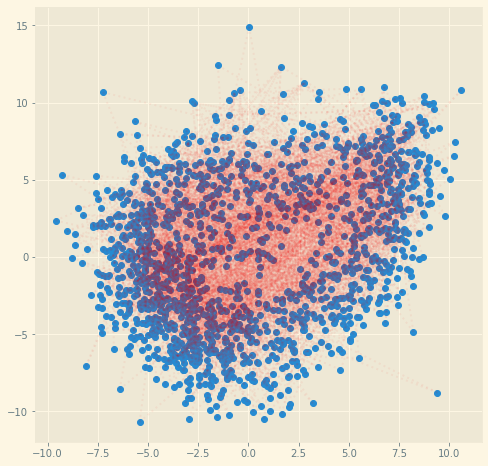

In [1566]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(dcData[:2].to_numpy().T):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        idx2 = connections.argmax()
        connections[idx2] = 0 # set to zero to find second largest connection
        idx3 = connections.argmax()
        x2, y2 = dcData.iloc[:, idx2][:2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05), linestyle=':')
        x3, y3 = dcData.iloc[:, idx3][:2]
        ax.plot([x1, x3], [y1, y3], color=(1, 0, 0, 0.05), linestyle=':')
    ax.scatter(*dcData[:2].to_numpy())
    #fig.savefig("../../Plots/")

In [13]:
from sklearn.cluster import SpectralClustering

In [18]:
clustering = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psis[1]))
print(clustering.labels_)

[0 0 0 ... 0 0 0]


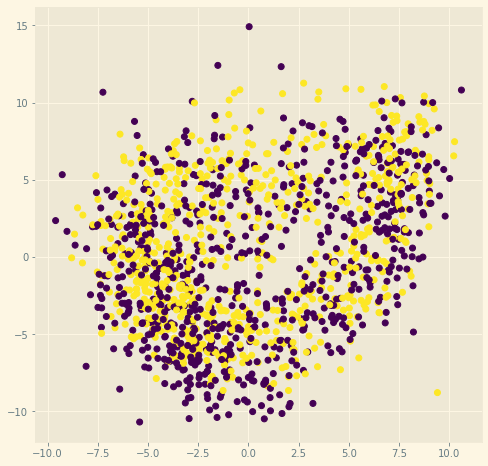

In [19]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    cov_mat = np.linalg.inv(Psis[1])
    ax.scatter(*dcData[:2].to_numpy(), c=clustering.labels_)
    #fig.savefig("../../Plots/")

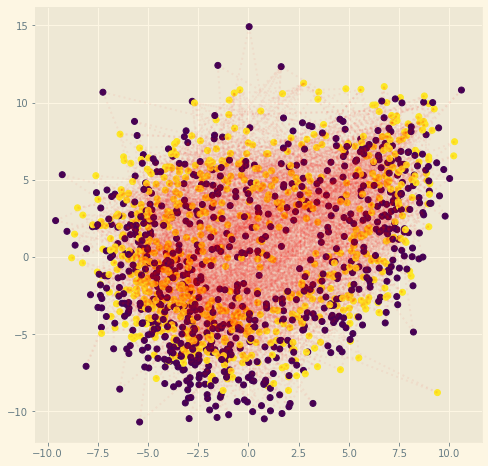

In [20]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    cov_mat = np.linalg.inv(Psis[1])
    for idx, (x1, y1) in enumerate(dcData[:2].to_numpy().T):
        connections = np.abs(cov_mat[idx])
        connections[idx] = 0 # set diagonal to zero
        idx2 = connections.argmax()
        connections[idx2] = 0 # set to zero to find second largest connection
        idx3 = connections.argmax()
        x2, y2 = dcData.iloc[:, idx2][:2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, 0.05), linestyle=':')
        x3, y3 = dcData.iloc[:, idx3][:2]
        ax.plot([x1, x3], [y1, y3], color=(1, 0, 0, 0.05), linestyle=':')
    ax.scatter(*dcData[:2].to_numpy(), c=clustering.labels_)
    #fig.savefig("../../Plots/")

In [1568]:
clustering = SpectralClustering(
    n_clusters=5,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(np.linalg.inv(Psis[1])))
print(clustering.labels_)

[0 0 0 ... 0 0 4]


In [1576]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    cov_mat = np.linalg.inv(Psis[1])
    ax.scatter(*dcData[:2].to_numpy(), c=clustering.labels_)
    fig.savefig("../../Plots/Cell Cycle/Spectral Clustering with CovMat in DCspace.png")

In [1581]:
rawData = pd.read_csv("../../Data/revelioTestData_rawDataMatrix.csv").set_index("Unnamed: 0")
rawData

WT_CTTGTAGCGTCT  WT_AATTTAAACTTG  WT_GACAACCTCATC  \
Unnamed: 0                                                      
A1BG                      0                0                0   
A2M                       0                0                0   
A2M-AS1                   0                0                0   
A2MP1                     0                0                0   
A4GALT                    0                0                0   
...                     ...              ...              ...   
ZYG11A                    1                0                0   
ZYG11B                    3                0                1   
ZYX                       4                1                1   
ZZEF1                     0                0                1   
ZZZ3                      5                1                0   

            WT_ACCATACACACG  WT_TTTCAGGCAGAC  WT_TGTATCTTATAT  \
Unnamed: 0                                                      
A1BG                      0                0                0   
A2M                       0                0                0   
A2M-AS1                   0                0                0   
A2MP1                     0                0                0   
A4GALT                    0                0                0   
...                     ...              ...              ...   
ZYG11A                    0                0                0   
ZYG11B                    1                2                3   
ZYX                       3                6                2   
ZZEF1                     1                0                0   
ZZZ3                      3                6                1   

            WT_AAATGTGTCTTC  WT_GTGTCAGGAGCA  WT_CCCGAAGTTATC  \
Unnamed: 0                                                      
A1BG                      0                0                0   
A2M                       0                0                0   
A2M-AS1                   2                1                0   
A2MP1                     0                0                0   
A4GALT                    2                0                0   
...                     ...              ...              ...   
ZYG11A                    0                1                0   
ZYG11B                    3                0                1   
ZYX                       1                3                3   
ZZEF1                     3                0                0   
ZZZ3                      3                4                1   

            WT_AACATTGGAACC  ...  Ago2KO_ATCTTATTTGGC  Ago2KO_TGTTATTGCCTG  \
Unnamed: 0                   ...                                             
A1BG                      0  ...                    0                    0   
A2M                       0  ...                    0                    0   
A2M-AS1                   0  ...                    0                    0   
A2MP1                     0  ...                    0                    0   
A4GALT                    2  ...                    0                    0   
...                     ...  ...                  ...                  ...   
ZYG11A                    0  ...                    0                    0   
ZYG11B                    0  ...                    0                    0   
ZYX                       1  ...                    0                    0   
ZZEF1                     1  ...                    0                    0   
ZZZ3                      0  ...                    0                    0   

            Ago2KO_GAAGCAGTCTGG  Ago2KO_AACTGTCGCCAC  Ago2KO_ACCCTCTCTTCG  \
Unnamed: 0                                                                  
A1BG                          0                    0                    0   
A2M                           0                    0                    0   
A2M-AS1                       0                    0                    0   
A2MP1                         0                    0                    0 

In [1584]:
rawData[rawData.sum(axis=1) >= 5, rawData.sum(axis=0) >= 500]

InvalidIndexError: (slice(None, None, None), WT_CTTGTAGCGTCT        True
WT_AATTTAAACTTG        True
WT_GACAACCTCATC        True
WT_ACCATACACACG        True
WT_TTTCAGGCAGAC        True
                       ... 
Ago2KO_TGAGGCATGATG    True
Ago2KO_AAGCATTTAAGT    True
Ago2KO_TGCGTCTAGGTG    True
Ago2KO_GAACACTTAAAN    True
Ago2KO_GCCTAACAATCN    True
Length: 1564, dtype: bool)

1) antGLasso the raw count data

2) Spectrally cluster the cells

3) Plot in DC space

4) Save the clusters

5) Feed the differential expressions into a GO term analysis

6) ???

7) Profit

In [21]:
counts = pd.read_csv("../../Data/countData.csv").set_index("Unnamed: 0")
counts

WT_CTTGTAGCGTCT  WT_AATTTAAACTTG  WT_GACAACCTCATC  \
Unnamed: 0                                                      
A2M                       0                0                0   
A2MP1                     0                0                0   
A4GALT                    0                0                0   
AAAS                      3                3                1   
AACS                      2                1                2   
...                     ...              ...              ...   
ZYG11A                    1                0                0   
ZYG11B                    3                0                1   
ZYX                       4                1                1   
ZZEF1                     0                0                1   
ZZZ3                      5                1                0   

            WT_ACCATACACACG  WT_TTTCAGGCAGAC  WT_TGTATCTTATAT  \
Unnamed: 0                                                      
A2M                       0                0                0   
A2MP1                     0                0                0   
A4GALT                    0                0                0   
AAAS                      1                2                2   
AACS                      2                1                0   
...                     ...              ...              ...   
ZYG11A                    0                0                0   
ZYG11B                    1                2                3   
ZYX                       3                6                2   
ZZEF1                     1                0                0   
ZZZ3                      3                6                1   

            WT_AAATGTGTCTTC  WT_GTGTCAGGAGCA  WT_CCCGAAGTTATC  \
Unnamed: 0                                                      
A2M                       0                0                0   
A2MP1                     0                0                0   
A4GALT                    2                0                0   
AAAS                      2                1                0   
AACS                      1                1                0   
...                     ...              ...              ...   
ZYG11A                    0                1                0   
ZYG11B                    3                0                1   
ZYX                       1                3                3   
ZZEF1                     3                0                0   
ZZZ3                      3                4                1   

            WT_AACATTGGAACC  ...  Ago2KO_TTAAAGGGGGCT  Ago2KO_CATAACCTCGTT  \
Unnamed: 0                   ...                                             
A2M                       0  ...                    0                    0   
A2MP1                     0  ...                    0                    0   
A4GALT                    2  ...                    0                    0   
AAAS                      0  ...                    0                    1   
AACS                      0  ...                    0                    0   
...                     ...  ...                  ...                  ...   
ZYG11A                    0  ...                    0                    0   
ZYG11B                    0  ...                    0                    0   
ZYX                       1  ...                    0                    0   
ZZEF1                     1  ...                    0                    0   
ZZZ3                      0  ...                    0                    0   

            Ago2KO_ACGAGACTCTGC  Ago2KO_ATCTTATTTGGC  Ago2KO_AACTGTCGCCAC  \
Unnamed: 0                                                                  
A2M                           0                    0                    0   
A2MP1                         0                    0                    0   
A4GALT                        0                    0                    0   
AAAS                          0                    0                    0 

In [22]:
from Scripts.anBiGLasso import calculate_empirical_covariances
Psis = antGLasso_heuristic(
    calculate_empirical_covariances(np.log(counts.to_numpy()+1)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)

In [23]:
np.save("../../Data/CellPrecisions.npy", Psis[1])

In [24]:
from sklearn.cluster import SpectralClustering

In [25]:
clustering = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(np.linalg.inv(Psis[1])))
print(clustering.labels_)

[0 0 0 ... 1 1 1]


In [29]:
counts.loc[:, clustering.labels_ == 0].to_csv("../../Data/cluster0.csv")
counts.loc[:, clustering.labels_ == 1].to_csv("../../Data/cluster1.csv")
counts.loc[:, clustering.labels_ == 2].to_csv("../../Data/cluster2.csv")
counts.loc[:, clustering.labels_ == 3].to_csv("../../Data/cluster3.csv")
counts.loc[:, clustering.labels_ == 4].to_csv("../../Data/cluster4.csv")

In [30]:
counts.loc[:, clustering.labels_ == 4]

WT_AAATCAAATTCC  WT_TCGCGAAATCGT  WT_TGCCATCTGGGG  \
Unnamed: 0                                                      
A2M                       0                0                0   
A2MP1                     0                0                0   
A4GALT                    0                0                0   
AAAS                      0                0                2   
AACS                      0                0                0   
...                     ...              ...              ...   
ZYG11A                    1                0                0   
ZYG11B                    0                1                0   
ZYX                       1                2                0   
ZZEF1                     0                0                0   
ZZZ3                      0                0                1   

            WT_TACTTAACTGTN  WT_CGAACTGCTACT  WT_ACTGAAAACCGT  \
Unnamed: 0                                                      
A2M                       0                0                0   
A2MP1                     0                0                0   
A4GALT                    1                0                0   
AAAS                      0                0                0   
AACS                      0                0                0   
...                     ...              ...              ...   
ZYG11A                    0                0                0   
ZYG11B                    0                0                0   
ZYX                       0                0                0   
ZZEF1                     0                0                0   
ZZZ3                      0                0                0   

            WT_ACGAATCATCGC  WT_AATTATGGTAAT  WT_TCTCAACCGAGT  \
Unnamed: 0                                                      
A2M                       0                0                0   
A2MP1                     0                0                0   
A4GALT                    0                0                0   
AAAS                      0                0                0   
AACS                      0                0                0   
...                     ...              ...              ...   
ZYG11A                    0                0                0   
ZYG11B                    0                0                0   
ZYX                       0                1                0   
ZZEF1                     0                0                0   
ZZZ3                      0                1                0   

            WT_ACAGCGGGACGA  ...  Ago2KO_GGACAGACATAC  Ago2KO_AGCTTCTCAAAT  \
Unnamed: 0                   ...                                             
A2M                       0  ...                    0                    0   
A2MP1                     0  ...                    0                    0   
A4GALT                    0  ...                    0                    0   
AAAS                      0  ...                    0                    0   
AACS                      0  ...                    0                    0   
...                     ...  ...                  ...                  ...   
ZYG11A                    0  ...                    0                    0   
ZYG11B                    0  ...                    0                    1   
ZYX                       1  ...                    0                    0   
ZZEF1                     0  ...                    0                    0   
ZZZ3                      1  ...                    0                    0   

            Ago2KO_TTAAAGGGGGCT  Ago2KO_CATAACCTCGTT  Ago2KO_ACGAGACTCTGC  \
Unnamed: 0                                                                  
A2M                           0                    0                    0   
A2MP1                         0                    0                    0   
A4GALT                        0                    0                    0   
AAAS                          0                    1                    0 

In [22]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    cov_mat = np.linalg.inv(Psis[1])
    ax.scatter(*counts[:2].to_numpy(), c=clustering.labels_)
    #fig.savefig("../../Plots/Cell Cycle/Spectral Clustering with CovMat in DCspace.png")

In [26]:
gene_counts = counts.mean(axis=1)
cluster0 = counts.loc[:, clustering.labels_ == 0].mean(axis=1) - gene_counts
cluster1 = counts.loc[:, clustering.labels_ == 1].mean(axis=1) - gene_counts
#cluster2 = counts.loc[:, clustering.labels_ == 2].mean(axis=1) - gene_counts
#cluster3 = counts.loc[:, clustering.labels_ == 3].mean(axis=1) - gene_counts
#cluster4 = counts.loc[:, clustering.labels_ == 4].mean(axis=1) - gene_counts
#cluster4

In [29]:
def print_for_copying(x: list):
    for x_ in x:
        print(x_)
    print("===")

clusters = [cluster0, cluster1]#, cluster2, cluster3, cluster4]
de_genes = []
for idx, cluster in enumerate(clusters):
    n = 100
    n_largest = cluster.nlargest(n)#cluster.abs().nlargest(n)
    de_genes.append(cluster[n_largest.index.values].index.values)
    
print_for_copying(de_genes[0])

FTH1
RPLP1
FTL
RPS2
RPS3
RPS18
RPL37
RPS14
TMSB10
RPS8
RPS27A
B2M
RPS6
RPL19
RPL35
S100A6
RPL11
RPL31
TMSB4X
PABPC1
S100A4
RPL27
GAPDH
RPS4X
RPLP0
RPS19
HSP90AB1
RPL13A
RPS23
TXN
RPS13
RPL35A
RPS20
RPL12
HSP90AA1
NPM1
RPL27A
RPS5
RPL7A
RPL4
RPL32
PRDX1
PSMA7
RPS12
ENO1
RPS21
S100A11
RPL30
YBX1
GNB2L1
PTMA
RPS15A
RPS24
HNRNPA2B1
RPL6
LDHA
RPLP2
HSPD1
RPS11
RPL5
ANXA2
RPS29
NME2
RPL14
RPL23A
RPL3
ATP5G2
TM4SF1
SET
HINT1
UBA52
NDUFA4
RPL10
RPL38
RPL7
RPL24
SERF2
CCT5
KRT18
RPL21
RPL37A
RPSA
RPL34
MYL6
NACA
COX7B
S100A10
GAL
NCL
CD55
TPI1
LDHB
PKM
NUCKS1
ALDOA
PGK1
COX4I1
KRT10
BASP1
COX7C
===


In [30]:
print_for_copying(de_genes[1])

CCL5
FAM179A
RP1-43E13.2
RP11-24M17.4
DHX58
FAM21EP
RP13-735L24.1
GRK7
FRRS1
KCNIP2-AS1
IL22RA1
CTC-366B18.2
APOBEC3G
RP11-181G12.2
RP11-46F15.2
TEX22
MFSD4
TP53INP1
CTD-2587H24.10
CTD-2083E4.6
EYS
ITGA10
MYOM1
PPIEL
RP11-325L7.1
RP11-626G11.4
RUNDC3B
TSPEAR
UNC79
AC006547.15
AF131216.6
C7orf31
LINC00466
LINC00601
RP11-516C1.1
ZNF341-AS1
RP1-266L20.2
RP11-539G18.3
SLC11A1
AC105760.2
LINC01424
RP11-795F19.5
ALDH1L1
BAI3
BDNF-AS
CCDC146
CNIH2
CTD-2555K7.2
DAP3P1
DMC1
INCA1
LINC01356
LRRK2
NAA11
RP11-117L6.1
RP11-1H15.2
RP11-258F1.1
RP11-347E10.1
RP11-383C5.3
RP11-624M8.1
RP11-864I4.1
RP5-902P8.10
SPAG17
TMED11P
AC053503.4
ASB18
C1orf101
CCDC152
GS1-24F4.2
MURC
ZNF425
DNASE1L3
LLNLR-246C6.1
SBSPON
TGFB2-AS1
CFAP70
RP11-72M17.1
AANAT
AC002066.1
AC002454.1
AC003005.2
AC006547.13
AC010226.4
ADCY10P1
AP000721.4
B3GALT5
BX470102.3
C19orf71
C1orf168
C6orf47-AS1
C9
CASC21
CIB3
CLIP3
CSMD2
CTC-454I21.3
CTC-542B22.2
CTD-2269F5.1
CTD-2587M2.1
ETV7
===


In [57]:
print((clustering.labels_ == 0).sum())
print((clustering.labels_ == 1).sum())

357
1120


Unnamed: 0        FTH1      RPLP1        FTL       RPS2       RPS3      RPS18  \
0           138.004992  91.697519  77.614826  58.858231  53.998911  50.043198   
1                  NaN        NaN        NaN        NaN        NaN        NaN   

Unnamed: 0    RPL37      RPS14    TMSB10       RPS8  ...        C9    CASC21  \
0           48.0291  47.080051  46.14603  44.319792  ...       NaN       NaN   
1               NaN        NaN       NaN        NaN  ...  0.000647  0.000647   

Unnamed: 0      CIB3     CLIP3     CSMD2  CTC-454I21.3  CTC-542B22.2  \
0                NaN       NaN       NaN           NaN           NaN   
1           0.000647  0.000647  0.000647      0.000647      0.000647   

Unnamed: 0  CTD-2269F5.1  CTD-2587M2.1      ETV7  
0                    NaN           NaN       NaN  
1               0.000647      0.000647  0.000647  

[2 rows x 200 columns]

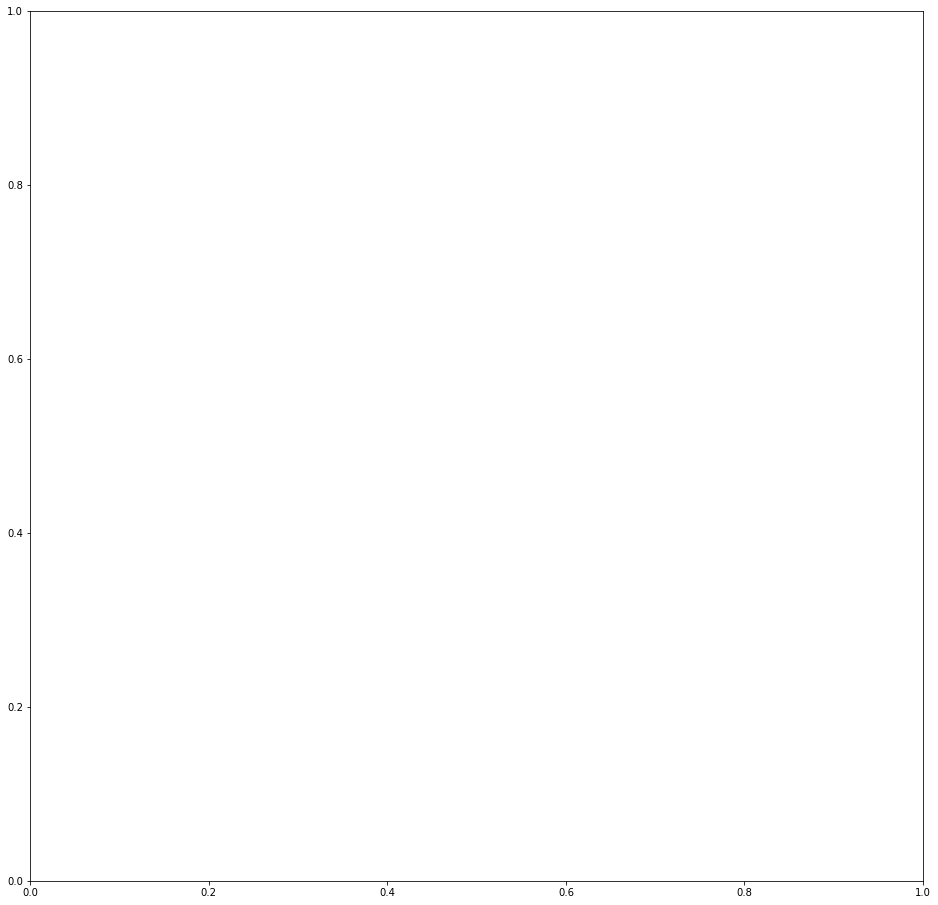

In [48]:
fig, ax = plt.subplots(figsize=(16, 16))
pd.DataFrame([
    cluster0[de_genes[0]],
    cluster1[de_genes[1]]
])

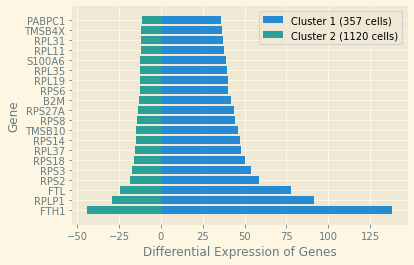

In [119]:
amount_to_show = 20
n_largest = cluster0.abs().nlargest(amount_to_show)
c0 = cluster[n_largest.index.values].index.values
n_largest = cluster1.abs().nlargest(amount_to_show)
c1 = cluster[n_largest.index.values].index.values
with plt.style.context("Solarize_Light2"):
    fig, ax = plt.subplots()
    ax.barh(
        np.arange(amount_to_show),
        cluster0[c0],
        label=f"Cluster 1 ({(clustering.labels_ == 0).sum()} cells)"
    )
    ax.barh(
        np.arange(amount_to_show),
        cluster1[c0],
        label=f"Cluster 2 ({(clustering.labels_ == 1).sum()} cells)"
    )
    ax.set_yticks(np.arange(amount_to_show))
    ax.set_yticklabels(c0)
    ax.set_xlabel("Differential Expression of Genes")
    ax.set_ylabel("Gene")
    ax.legend()

In [117]:
cluster0.index.values[8600:9600]

array(['RNF5', 'RNF6', 'RNF7', 'RNF8', 'RNFT1', 'RNFT1P3', 'RNFT2',
       'RNGTT', 'RNH1', 'RNMT', 'RNMTL1', 'RNPC3', 'RNPEP', 'RNPS1',
       'ROBO1', 'ROCK1', 'ROCK2', 'ROMO1', 'ROPN1L', 'ROR2', 'RORA',
       'RORA-AS1', 'RORB', 'RORC', 'RP1-102G20.5', 'RP1-117O3.2',
       'RP1-125I3.2', 'RP1-12G14.9', 'RP1-150O5.3', 'RP1-159A19.4',
       'RP1-167A14.2', 'RP1-179N16.6', 'RP1-197B17.3', 'RP1-20B21.4',
       'RP1-20N2.8', 'RP1-213J1P__B.1', 'RP1-21O18.3', 'RP1-234P15.4',
       'RP1-261D10.2', 'RP1-266L20.2', 'RP1-267L14.3', 'RP1-283E3.4',
       'RP1-283E3.8', 'RP1-292B18.3', 'RP1-309F20.3', 'RP1-313I6.12',
       'RP1-315G1.3', 'RP1-317E23.3', 'RP1-40E16.11', 'RP1-43E13.2',
       'RP1-59D14.1', 'RP1-78O14.1', 'RP1-80N2.2', 'RP1-90J20.8',
       'RP1-92O14.3', 'RP1-92O14.6', 'RP11-1000B6.3', 'RP11-1000B6.5',
       'RP11-1000B6.8', 'RP11-1007O24.3', 'RP11-1017G21.4',
       'RP11-1023L17.1', 'RP11-104N10.1', 'RP11-106M3.2', 'RP11-106M3.3',
       'RP11-1072C15.7', 'RP11-1079K10.

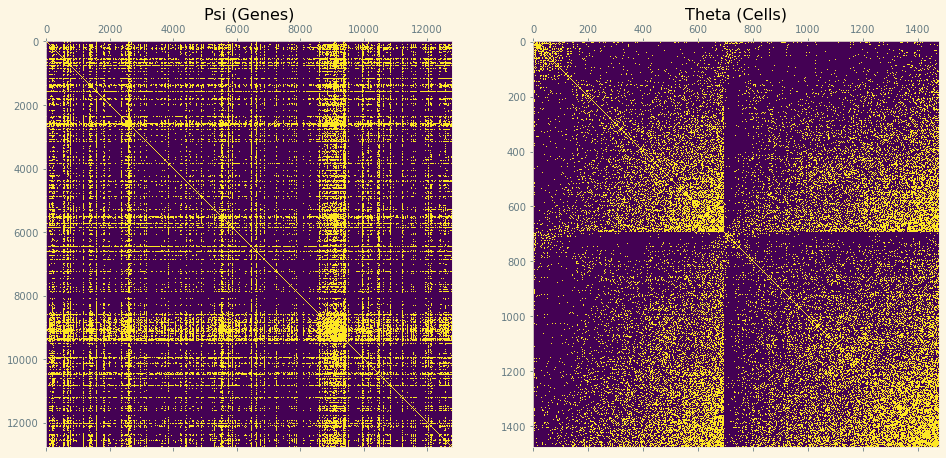

In [124]:
Psis_ = antGLasso_heuristic(
    calculate_empirical_covariances(np.log(counts.to_numpy()+1)[np.newaxis, ...]),
    sparsities=[0.2, 0.2],
    B_approx_iters=1000
)
Psi_ = binarize_matrix(Psis_[0], mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Psis_[1], mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, refigsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (Genes)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (Cells)')
    

In [125]:
Psis_ = antGLasso_heuristic(
    calculate_empirical_covariances(np.log(counts.to_numpy()+1)[np.newaxis, ...]),
    sparsities=[1, 1],
    B_approx_iters=1000
)

In [127]:
Psi_sorters = np.sort(np.abs(Psis_[0].reshape(-1)))
Theta_sorters = np.sort(np.abs(Psis_[1].reshape(-1)))

<IPython.core.display.Javascript object>


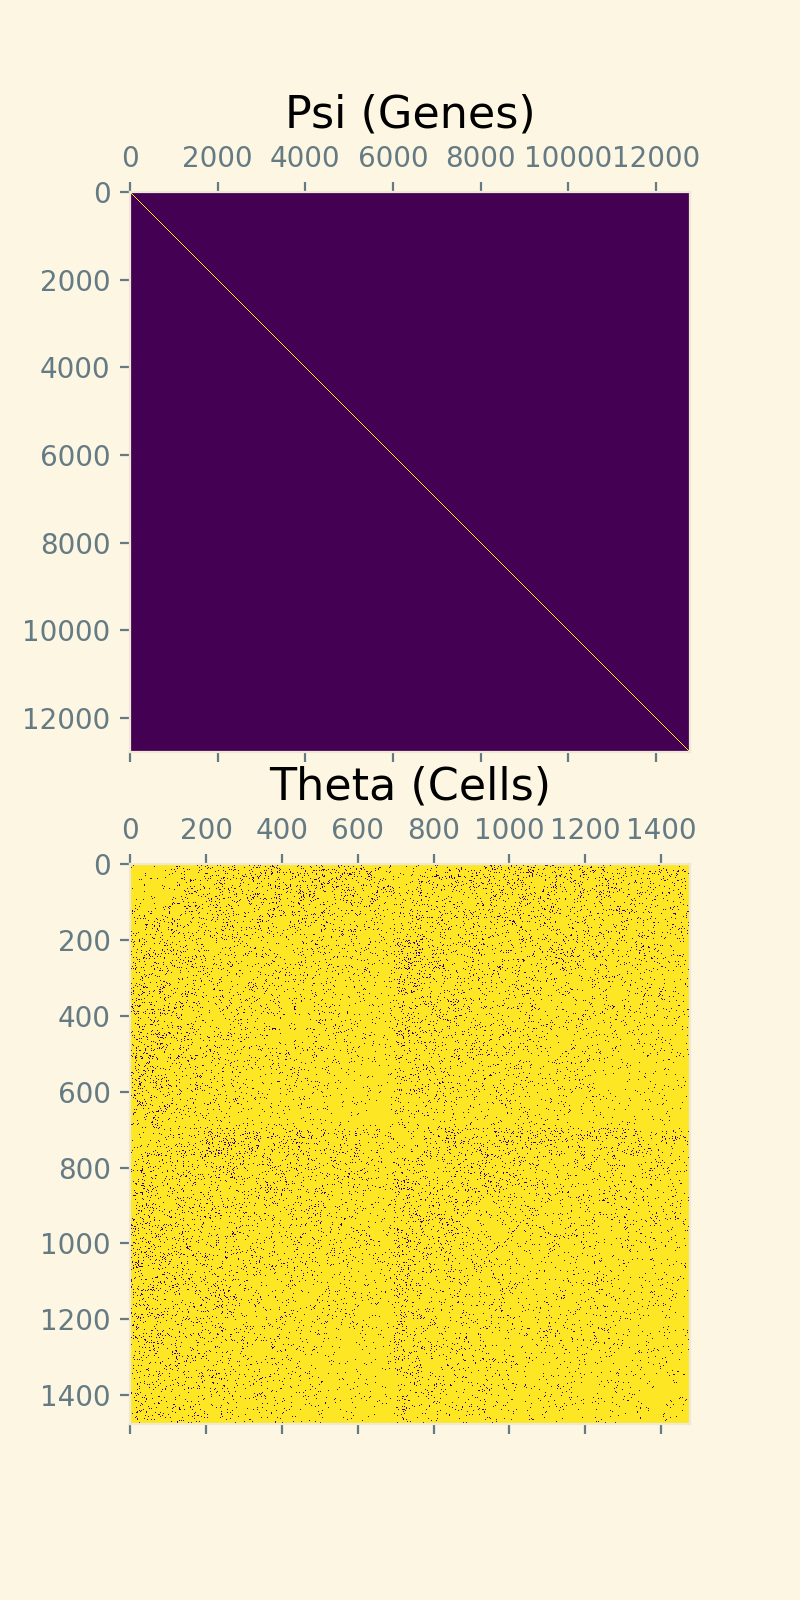

In [134]:
# Runs very slowly
num_frames = 500
from  matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
with plt.style.context('Solarize_Light2'):

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4, 8))

    ax1.grid(False)
    ax1.set_title('Psi (Genes)')
    Psi_ = np.zeros(Psis_[0].shape)
    np.fill_diagonal(Psi_, 1)
    mat_psi = ax1.matshow(Psi_)
    
    ax2.grid(False)
    ax2.set_title('Theta (Cells)')
    Theta_ = np.zeros(Psis_[1].shape)
    np.fill_diagonal(Theta_, 1)
    mat_theta = ax2.matshow(Theta_)
    

    def update(idx):
        #Psi_ = Psis_[0].copy()
        #Psi_[np.abs(Psi_) < Psi_sorters[
        #    int((idx/num_frames) * len(Psi_sorters))
        #]] = 0
        #Psi_ = binarize_matrix(Psi_, mode='Nonzero')
        #np.fill_diagonal(Psi_, 1)
        #mat_psi.set_data(Psi_)
        
        Theta_ = Psis_[1].copy()
        Theta_[np.abs(Theta_) < Theta_sorters[
            int((idx/num_frames) * len(Theta_sorters))
        ]] = 0
        Theta_ = binarize_matrix(Theta_, mode='Nonzero')
        np.fill_diagonal(Theta_, 1)
        mat_theta.set_data(Theta_)
        
        return [mat_psi, mat_theta]
    
    anim = FuncAnimation(fig, update, frames=num_frames, interval = 1, blit=True)

In [ ]:
from Scripts.antGLasso import shrink_sparsities
gene_ord = np.argsort(Psis_[0].sum(axis=0))[::-1]
Psi_, Theta_ = Psi, Theta = shrink_sparsities([
    Psis_[0][gene_ord][:, gene_ord],
    Psis_[1],
], [
    0.2, 0.01
])
Psi_ = binarize_matrix(Psi_, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta_, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (Genes)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (Cells)')
    

In [150]:
counts.index.values[gene_ord][:10]

array(['PCLO', 'RP11-347C12.12', 'BCAN', 'SLC26A4', 'CTC-459M5.2',
       'APOBEC3H', 'TEX14', 'SEMA6B', 'PLEKHB1', 'SELL'], dtype=object)

# Mouse Embryo Stem Cells

In [8]:
# Read the data
#mitosis_genes = pd.read_csv('../../Data/Nmythosis.txt')
G1_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/G1_singlecells_counts.txt',
    sep='\t'
).dropna()
G2M_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/G2M_singlecells_counts.txt',
    sep='\t'
).dropna()
S_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/S_singlecells_counts.txt',
    sep='\t'
).dropna()
#G1_df = G1_df[G1_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
#G2M_df = G2M_df[G2M_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
#S_df = S_df[S_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]

In [9]:
# Get matrix of counts
# (transpose needed to mimic scBiGLasso)
G1_mat = G1_df.iloc[:, 4:].to_numpy()
G2M_mat = G2M_df.iloc[:, 4:].to_numpy()
S_mat = S_df.iloc[:, 4:].to_numpy()
counts = np.concatenate([S_mat, G1_mat, G2M_mat], axis=1).T[np.newaxis, ...]
counts.shape

(1, 288, 38293)

In [10]:
counts_mini = counts[:, :, (counts.sum(axis=1) > 10000).squeeze()]
print(counts_mini.shape)
log_counts = np.log(counts_mini + 1)

(1, 288, 8112)


In [28]:
from Scripts.antGLasso import antGLasso_heuristic
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic
from Scripts.anBiGLasso import calculate_empirical_covariances

Ss = nonparanormal_tensor_skeptic(log_counts)#calculate_empirical_covariances(log_counts)

In [29]:
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[1, 1], B_approx_iters=1000)

In [15]:
from Scripts.antGLasso import shrink_sparsities
from Scripts.utilities import binarize_matrix

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


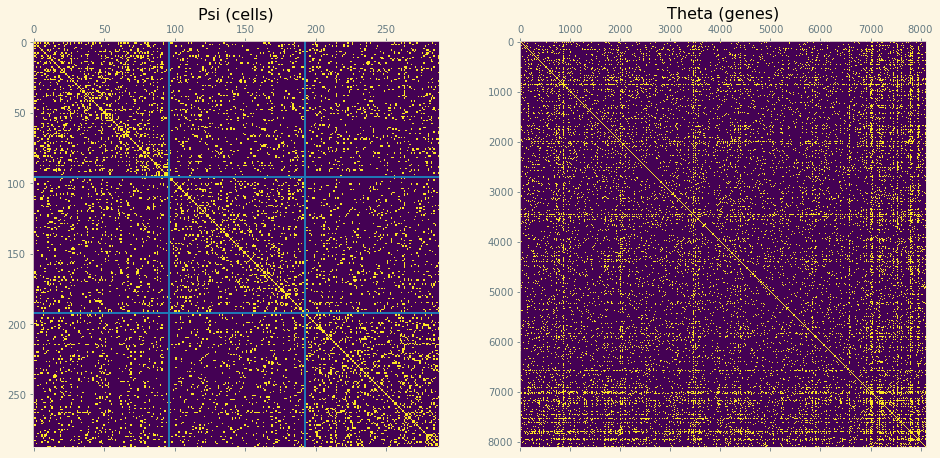

In [36]:
Psi_, Theta_ = shrink_sparsities([Psi, Theta], [0.1, 0.1])
Psi_ = binarize_matrix(Psi_, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta_, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Final/antGLasso Performance Nonpara Many Genes.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

In [21]:
from sklearn.cluster import SpectralClustering

In [34]:
clustering = SpectralClustering(
    n_clusters=3,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psi))
print(clustering.labels_)

[1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
from Scripts.antGLasso import antGLasso_heuristic
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic
from Scripts.anBiGLasso import calculate_empirical_covariances

Ss = calculate_empirical_covariances(log_counts)

In [37]:
Psi, Theta = antGLasso_heuristic(Ss, sparsities=[1, 1], B_approx_iters=1000)

In [40]:
Psi_, Theta_ = shrink_sparsities([Psi, Theta], [0.1, 0.1])
Psi_ = binarize_matrix(Psi_, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta_, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
    fig.savefig('../../Plots/Final/antGLasso Performance Empirical Many Genes.png')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


In [ ]:
# Idea: take the mitosis genes as a group and see if they're related to eachother!